# World Data League 2022

## 🎯 Challenge
**Predicting a safety score for Women in Costa Rica** by Urbanalytica


## Team: DataBased
## 👥 Authors
* André Luís
* Rui Monteiro
* José Diogo Castro

## 💻 Development

### 1. Context

Costa Rica is a country in Central America with a population of around 5  million in a land area of 51 060 km2. An estimated 333 980 people live in the capital and largest city, San José, with around two million people in the surrounding metropolitan area. The country has 7 administrative provinces: Alajuela, Cartago, Guanacaste, Heredia, Limon, Puntarenas and San Jose.

<img src="https://www.worldatlas.com/r/w1200/upload/04/72/12/provinces-of-costa-rica-map.png" alt="Costa Rica Map" width="550"/>

The challenge provider, Urbanalytica, has the mission to work for the development of smart, sustainable and just communities. This is why their team is worried about the safety of women in Costa Rica. Gender violence in cities, specifically in public spaces, has become an increasingly issue, especially in Latin America.

This is why we, DataBased, should help working on a mapping tool to identify and report cases when women feel like their right to enjoy public
spaces is being threatened. To fulfill the goals of this project, we should create a safety index based on the data in Costa Rica, and predict the trend of the safety index per geographic zone by trimester and by year.

The goal of this project is associated with United Nation’s **Sustainable Development Goal 11**, "Sustainable Cities and Communities", more specifically with its target 11.7: **"provide access to safe and inclusive green and public spaces"** [1].

<img src="https://ec.europa.eu/eurostat/documents/276524/8267079/E_INVERTED+SDG+goals_icons-individual-RGB-11.png/aa706ac3-a6eb-46ac-83e0-a982ac4e36bf?t=1506689568969" alt="SDG 11" width="200"/>

### 2. Data Sources

a) ZIP file with Costa Rica's data ([link](https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/urbanalytica_datasets.zip)):
  - ArcGIS Zoning data;
  - Districts data;
  - Crimes data;
  - Street harassment data.

b) ZIP file with Google reviews for parks and transit stations in Costa Rica ([link](https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/google_reviews.zip))

### 3. Introduction

Violence against women is "any act or conduct, based on gender, which causes death or physical, sexual or psychological harm or suffering to women, whether in the public or the private sphere" [2]. It is important to note that in 2020, a law against street sexual harassment was implemented in Costa Rica [3].

According to the United Nations Entity for Gender Equality and the Empowerment of Women, the lack of adequate urban infrastructure, policies, and governance models exacerbate gender violence in cities [4]. Thus, addressing the main obstacles women face regarding their right to an inclusive and safe city, becomes a priority.

Also, according to police statistics, 70.6% of complaints of street sexual harassment in Costa Rica were submitted by women in 2019 [5]. While no current strategy from the public authorities is in place, women are raising their voices creating awareness groups on social media to report aggressions and missing persons.

Facts like these highlight the importance of Sustainable Development Goal 11. Having safe and inclusive public spaces is essential for a sustainable city.

#### 3.1) Women's Safety Index

According to the Women Peace and Security Index, which tracks sustainable peace through inclusion, justice, and security for women, Costa Rica ranks 45th among 167 countries [6].

The Women's Safety Index we are going to use on this project is mainly based on the crime data from the *costa_rica_crimes_english.csv* file. This is because one of the goals of the project is to predict the trend of the safety index by trimester and by year, so we need to use time series data. Thus, the proxy we will use for women security is the total number of crimes against women (that is what our models will predict).

This index will be calculated for 2 of the 11 districts in the **San Jose canton (district level)**, although in the future it can be expanded to all districts. We decided to focus on this city, because it is the capital of the country and where more data can be found.

The algorithm used to make our index predictions is the ARIMA (Autoregressive Integrated Moving Average) model.

We consider the following variables to be important to predict women safety in our models: Time of day, Type of victim, and Age.

### 4. Import and Assess Data

The first step is to import all the data needed for this project.

In [ ]:
# INSTALL REQUIRED PACKAGES
!pip install geopandas

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os
import glob
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import statistics
import json
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
from itertools import product
from pandas import json_normalize
import plotly.express as px
from wordcloud import WordCloud
import re
import plotly.graph_objects as go
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm_notebook
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.preprocessing import MinMaxScaler

custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Declare the directory path for the data files
path = '/content/gdrive/Shareddrives/WDL - DataBased/Semi-Finals/data'

#### 4.1) ArcGIS Zoning Data

This data is related to San Jose, the capital of Costa Rica. It includes:
- arcGIS_districts - arcGIS data on the borders of 11 Districts in San Jose
- arcGIS_centro_vias - arcGIS data on road centers. The Road Centers coverage of the road network is made up of the lines drawn through the center and along the roads of the San José canton and contains, among other fields, the road nomenclature of the canton
- arcGIS_areas_public_use - arcGIS data on areas of public use in the San Jose canton
- arcGIS_security - arcGIS data on security related buildings in the San Jose canton
- arcGIS_green_areas - arcGIS data on green areas in the San Jose canton
- arcGIS_healthcare - arcGIS data on healthcare related buildings in the San Jose canton
- arcGIS_churches - arcGIS data on churches/temples in the San Jose canton
- arcGIS_education - arcGIS data on education related buildings in the San Jose canton
- arcGIS_entertainment_culture - arcGIS data on buildings/areas related to entertainment and culture in the San Jose canton
- arcGIS_governmental - arcGIS data on government buildings in the San Jose canton
- arcGIS_communal_areas - arcGIS data on communal areas in the San Jose canton
- arcGIS_commercial_centers - arcGIS data on commercial centers in the San Jose canton
- arcGIS_housing_complexes - arcGIS data on housing complexes in the San Jose canton
- arcGIS_susceptibilidad - arcGIS data on zones susceptible to landslides and floods in the San Jose canton
- arcGIS_catasto_predios - arcGIS data on property boundries of estates
- arcGIS_catasto_bloque - arcGIS data on property boundries of blocks
- arcGIS_catasto_vias - arcGIS data on Vias Catastrales (Cadastral roads)
- arcGIS_catasto_codominios - arcGIS data on the property boundaries of condos in San Jose
- arcGIS_catasto_central - arcGIS data on the San Jose city center
- arcGIS_patrimonio - arcGIS data on heritage buildings as well as boulevards and urban crossings in the San Jose canton
- arcGIS_zonas - arcGIS data on land use zones in the San Jose canton
- arcGIS_retiros - arcGIS data on how close to specific roads buildings can be built (setbacks) in the San Jose canton
- arcGIS_vialidad - arcGIS data on national and local roads in the San Jose canton
- arcGIS_agua - arcGIS data on bodies of water in the San Jose canton

In [ ]:
# Use glob to get all the csv files in the folder
csv_files = glob.glob(os.path.join(path + '/arcGIS_zoning_data_san_jose/', '*.csv'))

zoning_data = {}

# Loop over the list of csv files
for f in csv_files:
    # Read the csv file
    df = pd.read_csv(f)
    
    # Get the name of the file
    name = f.split('/')[-1].split('.')[-2]
    
    # Save files in the zoning_data dictionary
    zoning_data[name] = df

In [ ]:
zoning_data['arcGIS_districts'].head()

,Unnamed: 0,OBJECTID,Id_Distrito,Nombre,Shape.STArea(),Shape.STLength(),SHAPE
0,0,71,1,CARMEN,1.483688e+06,6082.723674,"{'rings': [[[492433.0192999998, 1099202.651799..."
1,1,72,2,MERCED,2.203397e+06,8054.017506,"{'rings': [[[490788.4051999999, 1099692.856899..."
2,2,75,10,HATILLO,4.317557e+06,12262.463423,"{'rings': [[[487494.0371000003, 1098047.898399..."
3,3,76,3,HOSPITAL,3.321154e+06,8505.195897,"{'rings': [[[491326.8503999999, 1098441.059599..."
4,4,77,4,CATEDRAL,2.361996e+06,7376.717783,"{'rings': [[[492975.9068999998, 1098199.7193],..."


In [ ]:
zoning_data_list = list(zoning_data.keys())

print('\033[1mZoning datasets:\n\033[0m')

for i in zoning_data_list:
    print(i)

Zoning datasets:

arcGIS_districts
arcGIS_centro_vias
arcGIS_areas_public_use
arcGIS_security
arcGIS_green_areas
arcGIS_healthcare
arcGIS_churches
arcGIS_education
arcGIS_entertainment_culture
arcGIS_governmental
arcGIS_communal_areas
arcGIS_commercial_centers
arcGIS_housing_complexes
arcGIS_susceptibilidad
arcGIS_catasto_predios
arcGIS_catasto_bloque
arcGIS_catasto_vias
arcGIS_catasto_codominios
arcGIS_catasto_central
arcGIS_patrimonio
arcGIS_zonas
arcGIS_retiros
arcGIS_vialidad
arcGIS_agua


This ArcGIS data can be visualized here:
- https://msjcr.maps.arcgis.com/apps/webappviewer/index.html?id=2fee9920df334d6688c2eaf0e749349c
- https://msjcr.maps.arcgis.com/apps/webappviewer/index.html?id=7da481f022c74e79882ca6052afad0ba

#### 4.2) Districts Data

This dataset has demographic, crime-rate data and Social Development Index 2017 at the district level.

In [ ]:
district = pd.read_csv(path + '/district_data.csv', index_col=0)

district.head()

,PCD,"{Provincia, Canton, Distrito}",Tasa de Asaltos por cada 10 mil habitantes,Tasa de Homicidios dolosos por cada 10 mil habitantes,Tasa de Hurtos por cada 10 mil habitantes,Tasa de Robos por cada 10 mil habitantes,Tasa de Robo de vehículos por cada 10 mil habitantes,Tasa de Violaciones por cada 10 mil habitantes,Económica,Participación electoral,...,Población total,Densidad de población,Porcentaje población urbana,Relación hombres mujeres,Relación dependencia demográfica,Porcentaje de población de 65 años y más,Porcentaje de población nacida en el extranjero,Porcentaje de personas unidas o casadas,Porcentaje de discapacidad,Porcentaje de población no asegurada
0,10101.0,"{""SAN JOSE"", ""SAN JOSE"", ""CARMEN""}",994.0,0.0,1010.0,204.0,74.0,6.0,68.48,41.11,...,2702.0,1813.422819,100.0,77.646285,46.927678,21.909696521095483,24.537380,36.151369,15.692080,13.286454
1,10102.0,"{""SAN JOSE"", ""SAN JOSE"", ""MERCED""}",355.0,4.0,327.0,60.0,21.0,7.0,41.70,39.93,...,12257.0,5352.401747,100.0,92.387380,45.345666,9.96981316798564,27.763727,45.705552,11.405727,18.103941
2,10103.0,"{""SAN JOSE"", ""SAN JOSE"", ""HOSPITAL""}",320.0,5.0,254.0,41.0,19.0,3.0,40.26,36.12,...,19270.0,5701.183432,100.0,94.528569,47.132931,10.37363777893098,20.249092,44.264355,15.474831,18.593669
3,10104.0,"{""SAN JOSE"", ""SAN JOSE"", ""CATEDRAL""}",352.0,5.0,378.0,71.0,32.0,1.0,47.08,43.00,...,12936.0,5600.000000,100.0,89.233470,45.774172,14.440321583178726,20.338590,40.436915,12.755102,14.169759
4,10105.0,"{""SAN JOSE"", ""SAN JOSE"", ""ZAPOTE""}",84.0,0.0,33.0,33.0,11.0,0.0,57.68,49.73,...,18679.0,6554.035088,100.0,86.995695,44.283949,13.914021093206275,9.508004,41.947956,11.547727,10.027303


In [ ]:
# Check dataset info
district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477 entries, 0 to 476
Data columns (total 24 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   PCD                                                    477 non-null    float64
 1   {Provincia, Canton, Distrito}                          477 non-null    object 
 2   Tasa de Asaltos por cada 10 mil habitantes             477 non-null    float64
 3   Tasa de Homicidios dolosos por cada 10 mil habitantes  477 non-null    float64
 4   Tasa de Hurtos por cada 10 mil habitantes              477 non-null    float64
 5   Tasa de Robos por cada 10 mil habitantes               477 non-null    float64
 6   Tasa de Robo de vehículos por cada 10 mil habitantes   477 non-null    float64
 7   Tasa de Violaciones por cada 10 mil habitantes         477 non-null    float64
 8   Económica                                         

In [ ]:
# Divide location column into "provincia", "canton" and "distrito"
location_df = district['{Provincia, Canton, Distrito}'].str.split(',', n=3, expand=True)
location_df.rename(columns={0:'provincia', 1:'canton', 2:'distrito'}, inplace = True)

# Remove unnecessary characters from the names of each province/canton/district
location_df['provincia'] = location_df['provincia'].str.replace('"', '')
location_df['provincia'] = location_df['provincia'].str.replace('{', '')
location_df['canton'] = location_df['canton'].str.replace('"', '')
location_df['canton'] = location_df['canton'].str[1:]
location_df['distrito'] = location_df['distrito'].str.replace('"', '')
location_df['distrito'] = location_df['distrito'].str.replace('}', '')
location_df['distrito'] = location_df['distrito'].str[1:]

# Update values on the district df
district['provincia'] = location_df['provincia']
district['canton'] = location_df['canton']
district['distrito'] = location_df['distrito']

In [ ]:
# Analyse only the San Jose canton
district_sj = district.loc[district['canton']=='SAN JOSE']

In [ ]:
# In the canton of San Jose, there are a total of 11 districts
district_sj.shape

(11, 27)

In [ ]:
# Analyse the district that has the highest value on each variable
variables = district_sj.columns.tolist()

not_variables = ['PCD', '{Provincia, Canton, Distrito}', 
                 'provincia', 'canton', 'distrito']
                 
variables = list(set(variables) - set(not_variables))

# Set the district names as index
district_sj.set_index('distrito', inplace=True)

# Check in which district is the maximum of each variable
maxs = pd.DataFrame({'Maximum in:': None}, index=variables)
district_sj['Porcentaje de población de 65 años y más'] = pd.to_numeric(district_sj['Porcentaje de población de 65 años y más'])

for i in maxs.index:
    maxs.at[i, 'Maximum in:'] = district_sj[i].idxmax()

maxs

,Maximum in:
Participación electoral,SAN FRANCISCO DE DOS RIOS
Económica,MATA REDONDA
Salud,MATA REDONDA
Porcentaje de población de 65 años y más,CARMEN
Tasa de Asaltos por cada 10 mil habitantes,CARMEN
Porcentaje de discapacidad,CARMEN
Relación hombres mujeres,HOSPITAL
Porcentaje población urbana,CARMEN
Tasa de Homicidios dolosos por cada 10 mil habitantes,HOSPITAL
IDS 2017,MATA REDONDA


In [ ]:
# Drop unnecessary columns
district_sj = district_sj.drop(columns=['PCD', '{Provincia, Canton, Distrito}', 'provincia', 'canton'])

#### 4.3) Crimes Data

This dataset has crime records for Costa Rica from 2010 to 2022.

In [ ]:
costa_rica_crimes = pd.read_csv(path + '/costa_rica_crime_data_english/costa_rica_crimes_english.csv',
                                index_col=0)

costa_rica_crimes.head()

,Crime,SubtypeCrime,Date,Time,SubtypeVictim,Age,Gender,Nationality,Province,Canton,District
0,ASSAULT,COLD WEAPON,08.01.22,06:00:00 - 08:59:59,LOTTERY SELLER [PERSON],>18 y/o,female,COSTA RICA,SAN JOSE,SAN JOSE,HOSPITAL
1,ASSAULT,COLD WEAPON,12.01.22,12:00:00 - 14:59:59,PUBLIC SERVICE/LEGAL OR ILLEGAL TAXI/BUS [VEHI...,unknown,unknown,Desconocido,PUNTARENAS,PUNTARENAS,CHACARITA
2,ASSAULT,COLD WEAPON,13.01.22,18:00:00 - 20:59:59,PEDESTRIAN [PERSON],>18 y/o,female,COSTA RICA,SAN JOSE,ASERRI,ASERRI
3,ASSAULT,COLD WEAPON,15.01.22,03:00:00 - 05:59:59,PEDESTRIAN [PERSON],>18 y/o,male,NICARAGUA,SAN JOSE,ASERRI,ASERRI
4,ASSAULT,COLD WEAPON,13.01.22,15:00:00 - 17:59:59,PEDESTRIAN [PERSON],>18 y/o,female,COSTA RICA,SAN JOSE,SAN JOSE,HOSPITAL


In [ ]:
# Filter only crimes that took place in the canton of San Jose
crimes_san_jose = costa_rica_crimes.loc[costa_rica_crimes['Canton'] == 'SAN JOSE']

In [ ]:
# Check the total number of crimes, both in the full country and in San Jose
print(f'There are {len(costa_rica_crimes):,} crimes registered in Costa Rica.')
print(f'{len(crimes_san_jose):,} crimes are registered in the canton of San Jose.')
print(f'This represents {len(crimes_san_jose)/len(costa_rica_crimes)*100:.2f}% of the total crimes in Costa Rica.')

There are 648,226 crimes registered in Costa Rica.
104,287 crimes are registered in the canton of San Jose.
This represents 16.09% of the total crimes in Costa Rica.


In [ ]:
# Check the percentage of crimes involving men and women victims (in San Jose)
crimes_san_jose['Gender'].value_counts(normalize=True)

male       0.616079
female     0.358674
unknown    0.025248
Name: Gender, dtype: float64

In [ ]:
# Check all types of crime
print(costa_rica_crimes['Crime'].unique())

['ASSAULT' 'HOMICIDE' 'THEFT' 'ROBBERY' 'VEHICLE THEFT'
 'VEHICLE VANDALISM']


In [ ]:
# Check all subtypes of crime
print(costa_rica_crimes['SubtypeCrime'].unique())

['COLD WEAPON' 'FIREARM' 'OUTBURST' 'SUFFOCATION/STRANGULATION' 'HITTING'
 'IMMOBILIZATION' 'VERBAL INTIMIDATION' 'OTHER OR UNDETERMINED' 'REVENGE'
 'ARGUMENT/FIGHT' 'NOT DETERMINED' 'PROFESSIONAL NEGLECT'
 'DECEIT/DISTRACTION' 'PICKPOCKETING'
 'FOR THE COMMISSION OF ANOTHER CRIME' 'AVOIDING CRIMINAL ACTIVITY'
 'WITH A WRENCH' 'PICKLOCK' 'DUE TO TRUST' 'UNKNOWN' 'FEMICIDE'
 'DUE TO NEGLECT' 'PROGRESSIVE THEFTS DURING THE DAY' 'ATM WITHDRAWAL'
 'USE OF SLEEPING PILLS' 'BREAKING AND ENTRY' 'CUT PADLOCKS' 'ESCALATION'
 'FORCE' 'BLINDS REMOVAL' 'BREAKING WINDOWS' 'ASSAULT' 'CARJACKING'
 'NEGLECT' 'VEHICLE VANDALISM' 'DOMESTIC VIOLENCE' 'VEHICLE THEFT'
 'USE OF GAS' 'IDEOLOGICAL']


In [ ]:
# Group 'Crime' and 'SubtypeCrime' in the same column
crimes_san_jose['group_crime'] = crimes_san_jose['Crime'] + ' (' + crimes_san_jose['SubtypeCrime'] + ')'

In [ ]:
# Types of crime where it is more common for women to be the victim (in San Jose)
crimes_san_jose.loc[crimes_san_jose['Gender']=='female']['group_crime'].value_counts(normalize=True)[:10]

THEFT (PICKPOCKETING)                    0.184494
THEFT (DUE TO NEGLECT)                   0.158187
ASSAULT (FIREARM)                        0.127790
ASSAULT (OUTBURST)                       0.118032
ASSAULT (COLD WEAPON)                    0.066783
VEHICLE VANDALISM (VEHICLE VANDALISM)    0.054431
ROBBERY (FORCE)                          0.045930
ASSAULT (HITTING)                        0.044700
THEFT (DUE TO TRUST)                     0.044299
THEFT (DECEIT/DISTRACTION)               0.032589
Name: group_crime, dtype: float64

In [ ]:
# Types of crime where it is more common for men to be the victim (in San Jose)
crimes_san_jose.loc[crimes_san_jose['Gender']=='male']['group_crime'].value_counts(normalize=True)[:10]

ASSAULT (FIREARM)                        0.209124
THEFT (DUE TO NEGLECT)                   0.121014
ASSAULT (COLD WEAPON)                    0.114523
VEHICLE VANDALISM (VEHICLE VANDALISM)    0.093807
THEFT (PICKPOCKETING)                    0.064546
ROBBERY (FORCE)                          0.048577
VEHICLE THEFT (NEGLECT)                  0.043518
THEFT (DUE TO TRUST)                     0.042086
ASSAULT (OUTBURST)                       0.037666
ASSAULT (HITTING)                        0.036934
Name: group_crime, dtype: float64

In [ ]:
# Convert column to datetime
crimes_san_jose['Date'] = pd.to_datetime(crimes_san_jose['Date'])

In [ ]:
# Drop unnecessary columns
crimes_san_jose = crimes_san_jose.drop(columns=['Province', 'Canton'])

#### 4.4) Street Harassment Data

This dataset has street harassment reported in 2021 in Costa Rica.


In [ ]:
street = pd.read_csv(path + '/costa_rica_street_harassement_english.csv')

street.head()

,province,canton,district,public_prosecutors_office,sexual_harassement,exhibitionism,pursuit_or_cornering,production_of_audiovisual_material,sexual_harassement_law
0,Heredia,Heredia,Heredia,Fiscalía Heredia (Adjunta),1,10,3,0,15
1,San Jose,Goicoechea,Calle Blancos,Fiscalía II Circuito San José (goicoechea),0,12,3,5,1
2,Cartago,Turrialba,Turrialba,Fiscalía Turrialba,14,1,0,2,0
3,Cartago,Cartago,Oriental,Fiscalía Cartago,0,10,4,3,0
4,Puntarenas,Perez Zeledon,San Isidro del General,Fiscalía I Circuito Zona Sur,1,7,8,0,0


In [ ]:
# List of Street Harassment crimes in Costa Rica
street.columns.drop(['province', 'canton', 'district', 'public_prosecutors_office']).tolist()

['sexual_harassement',
 'exhibitionism',
 'pursuit_or_cornering',
 'production_of_audiovisual_material',
 'sexual_harassement_law']

In [ ]:
street.shape

(56, 9)

In [ ]:
# Analyse the district that has the highest value on each variable
variables = street.columns.tolist()

not_variables = ['province', 'canton', 'district', 'public_prosecutors_office']
                 
variables = list(set(variables) - set(not_variables))

# Set the district names as index
street.set_index('district', inplace=True)

# Check in which district is the maximum of each variable
maxs = pd.DataFrame({'Maximum in:': None}, index=variables)

for i in maxs.index:
    maxs.at[i, 'Maximum in:'] = street[i].idxmax()

maxs

,Maximum in:
sexual_harassement,Turrialba
pursuit_or_cornering,San Isidro del General
production_of_audiovisual_material,Calle Blancos
sexual_harassement_law,Heredia
exhibitionism,Calle Blancos


In [ ]:
# Check data for the canton of San Jose
street_canton = street.loc[street['canton'] == 'San Jose']
street_canton.head()

,province,canton,public_prosecutors_office,sexual_harassement,exhibitionism,pursuit_or_cornering,production_of_audiovisual_material,sexual_harassement_law
district,,,,,,,,
Catedral,San Jose,San Jose,Unidad Trámite Rápido,0,1,5,2,4
Hatillo,San Jose,San Jose,Fiscalía Hatillo,7,1,0,1,0
Pavas,San Jose,San Jose,Fiscalía Pavas,5,4,0,0,0
Catedral,San Jose,San Jose,Fiscalía Turno Extraordinario San José,0,3,2,3,0
Catedral,San Jose,San Jose,Fiscalía I Circuito San José,0,2,1,0,1


In [ ]:
# Group all harassment crimes that happened in the same district
street_canton = street_canton.groupby(by='district').sum()

#### 4.5) Google Ratings and Reviews Data

There are 2 files containing Google ratings and reviews of parks in Costa Rica and transit stations in San Jose.

##### 4.5.1) Parks

In [ ]:
with open(path + '/google_reviews/google_reviews_parks.json', 'r') as f:
    park_df = json.load(f)

In [ ]:
# Normalize json into a pandas DataFrame
park_df = json_normalize(park_df['park_reviews'])
park_df = park_df.where(pd.notnull(park_df), None)

In [ ]:
# ⚙️ FEATURE ENGINEERING (Median, Standard Deviation and Text from low ratings) 
Medians = list()
Var = list()
Three_star_text = list()

for ind in park_df.index:
    reviews = park_df.loc[ind]['result.reviews']

    if reviews is None:
        median = None
        st_var = None
        text = None
    else:
        rating_vector = list()
        text = ''

        for review in reviews:
            rating_vector.append(review['rating'])
            if review['rating'] <= 3:
                text += review['text']
                
        rating_vector = np.asarray(rating_vector)
        median = statistics.median(rating_vector)
        st_var = np.std(rating_vector)

    Medians.append(median)
    Var.append(st_var)
    Three_star_text.append(text)

# Add features to the dataset
park_df['median'] = Medians
park_df['variance'] = Var
park_df['text'] = Three_star_text

In [ ]:
# Convert Formatted Address into DataFrame
location_df = park_df['result.formatted_address'].str.split(',', n=4, expand=True)

# Filter data by San Jose canton (Since the data is not all correctly formatted, we need 2 columns)
location_df = location_df[(location_df[3] == ' San José') | (location_df[2] == ' San José')]
location_indexes = location_df.index

# Filter park dataset
park_df = park_df.loc[location_indexes]

##### 4.5.2) Transit Stations

In [ ]:
with open(path + '/google_reviews/google_reviews_transit.json', 'r') as f:
  transit_df = json.load(f)

Since the Data Processing is similar to the one applied in the Parks Ratings, the Data Processing will not be presented here, but it can be consulted in **Appendix A**. 

After the processing stage, the data is displayed as:

In [ ]:
transit_df[['result.name', 'result.rating', 'median', 'variance', 'text']].head(4)

,result.name,result.rating,median,variance,text
1,Parada Estadio Nacional,3.8,3.0,1.200000,No whether protectionYou have to be careful at...
2,Cuatro Reinas,3.8,3.0,1.166190,Much improvement has to be made in security an...
5,Parada Rohrmoser,2.7,2.0,1.496663,"It is not pleasant at all.Terrible stop, very ..."
6,Guadalupe,2.3,1.5,1.639360,Guadalupe is a center of the east side of San ...


At this point we have managed to collect the data and process it accordingly to make it ready to explore and use.

### 5. Exploratory Data Analysis (EDA)

In this step we will do some data analysis to explore and visualize the data to uncover insights.

#### 5.1) Zoning in San Jose

We want to use this data to check how San Jose is in terms of public infrastructure. To do so, we are going to check:
- Areas of public use
- Green areas
- Security related buildings

**a) How many public areas are there for each category?**

In [ ]:
# Count each type of public area
type_of_area = zoning_data['arcGIS_areas_public_use']['CATEGORIA'].value_counts().reset_index()

In [ ]:
# Put invalid strings as NaN
zoning_data['arcGIS_areas_public_use']['AREA_REGISTRAL'] = \
zoning_data['arcGIS_areas_public_use']['AREA_REGISTRAL'].replace({'NO SE INDICA': np.nan, '': np.nan}).astype(float)

In [ ]:
# Check the total number of public areas and their area
total = type_of_area['CATEGORIA'].sum()
total_area = zoning_data['arcGIS_areas_public_use']['AREA_REGISTRAL'].drop_duplicates(keep='first').sum()

print(f'There are {total:,} public areas in San Jose.')
print(f'The public areas in San Jose have a total area of {round(total_area/1e+6, 2):,} square kilometers.')

There are 5,315 public areas in San Jose.
The public areas in San Jose have a total area of 9.12 square kilometers.


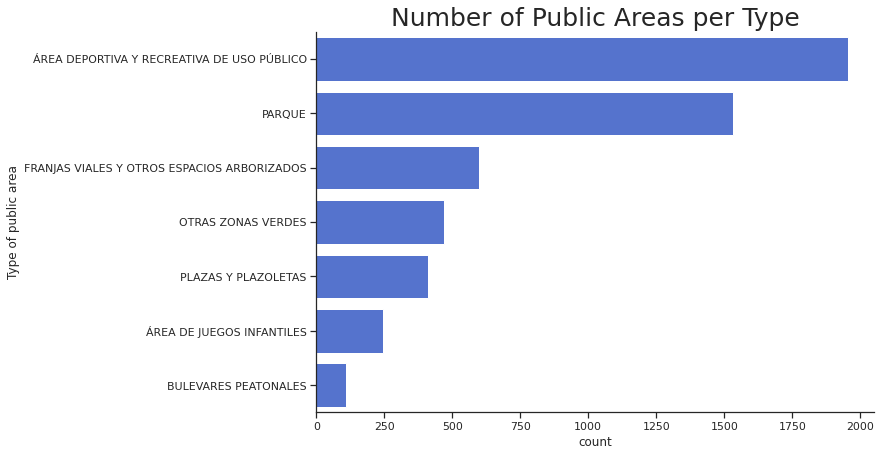

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=type_of_area, 
            x='CATEGORIA', 
            y='index', 
            color='royalblue',
            order=zoning_data['arcGIS_areas_public_use']['CATEGORIA'].value_counts().index
            )

plt.title('Number of Public Areas per Type', fontsize=25)
plt.xlabel('count')
plt.ylabel('Type of public area')
plt.show()

There are 5 315 public areas in San Jose, occupying 9.12 square kilometers. The majority are either sports and recreational areas, or parks. The least common are children playgrounds and pedestrian walkways.

**b) How many public areas are there on each district?**

In [ ]:
# Count the number of public areas per district
areas_per_district = zoning_data['arcGIS_areas_public_use']['ID_DISTRITO'].value_counts().reset_index()

# Get the area of each San Jose district in km2
zoning_data['arcGIS_districts']['Area_km2'] = zoning_data['arcGIS_districts']['Shape.STArea()'].astype(float)/1e+6

# Get the count for each district name
areas_per_district = zoning_data['arcGIS_districts'][['Id_Distrito', 'Nombre', 'Area_km2']]\
                            .merge(areas_per_district, how='left', left_on='Id_Distrito', right_on='index')

# Get the number of public areas per square kilometer
areas_per_district['p_areas_per_km2'] = areas_per_district['ID_DISTRITO']/areas_per_district['Area_km2']

# Sort values by descending order
areas_per_district = areas_per_district[['Nombre', 'p_areas_per_km2']].sort_values(by=['p_areas_per_km2'], ascending=False)

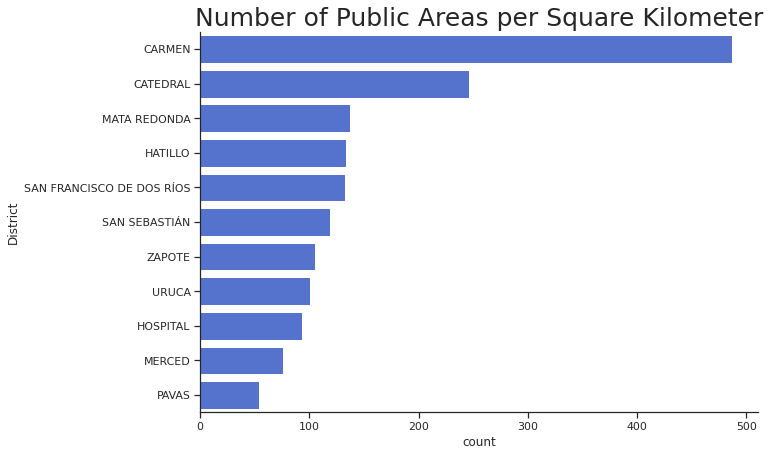

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=areas_per_district, 
            x='p_areas_per_km2', 
            y='Nombre', 
            color='royalblue'
            )

plt.title('Number of Public Areas per Square Kilometer', fontsize=25)
plt.xlabel('count')
plt.ylabel('District')
plt.show()

By the chart above, we can see that Carmen and Catedral districts have much more public area per square kilometer than the rest.

Carmen is the smallest district in terms of area, but it is the one with the highest area of public space per km2. Pavas, on the other hand, is the largest district, but it has the lowest area of public space per km2.

**c) How many public areas are managed by each type of owner?**

In [ ]:
# Count each type of owner (State, Municipal or Private)
type_of_owner = zoning_data['arcGIS_areas_public_use']['TIPO_PROPIETARIO'].value_counts().reset_index()

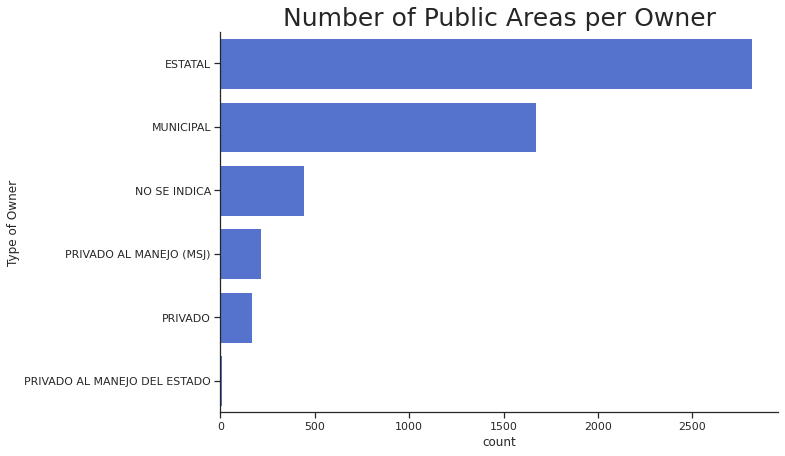

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=type_of_owner, 
            x='TIPO_PROPIETARIO', 
            y='index', 
            color='royalblue',
            order=zoning_data['arcGIS_areas_public_use']['TIPO_PROPIETARIO'].value_counts().index
            )

plt.title('Number of Public Areas per Owner', fontsize=25)
plt.xlabel('count')
plt.ylabel('Type of Owner')
plt.show()

We can see the vast majority of public spaces are managed either by the State of Costa Rica or by the San Jose's City Council. This is good, because if there is a need to change public areas in San Jose, the policy makers can implement those changes "directly".

**d) How many green areas are there for each category?**

In [ ]:
# Count each type of green area
type_of_green_area = zoning_data['arcGIS_green_areas']['CATEGORIA'].value_counts().reset_index()

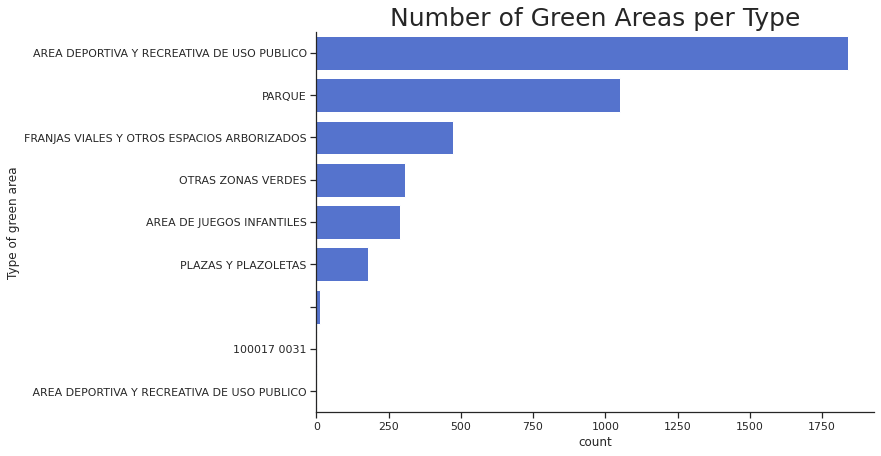

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=type_of_green_area, 
            x='CATEGORIA', 
            y='index', 
            color='royalblue',
            order=zoning_data['arcGIS_green_areas']['CATEGORIA'].value_counts().index
            )

plt.title('Number of Green Areas per Type', fontsize=25)
plt.xlabel('count')
plt.ylabel('Type of green area')
plt.show()

The majority of green areas in the city are sports/recreational areas or parks. Also, some are squares and plazas, and others are undisclosed.

**e) How many green areas are there on each district?**

In [ ]:
# Count the number of green areas on each district
type_of_green_area = zoning_data['arcGIS_green_areas']['ID_DISTRITO'].value_counts().reset_index()

# Get the count for each district name
type_of_green_area = zoning_data['arcGIS_districts'][['Id_Distrito', 'Nombre', 'Area_km2']]\
                            .merge(type_of_green_area, how='left', left_on='Id_Distrito', right_on='index')

# Get the number of green areas per square kilometer
type_of_green_area['g_areas_per_km2'] = type_of_green_area['ID_DISTRITO']/type_of_green_area['Area_km2']

# Sort values by descending order
type_of_green_area = type_of_green_area[['Nombre', 'g_areas_per_km2']].sort_values(by=['g_areas_per_km2'], ascending=False)

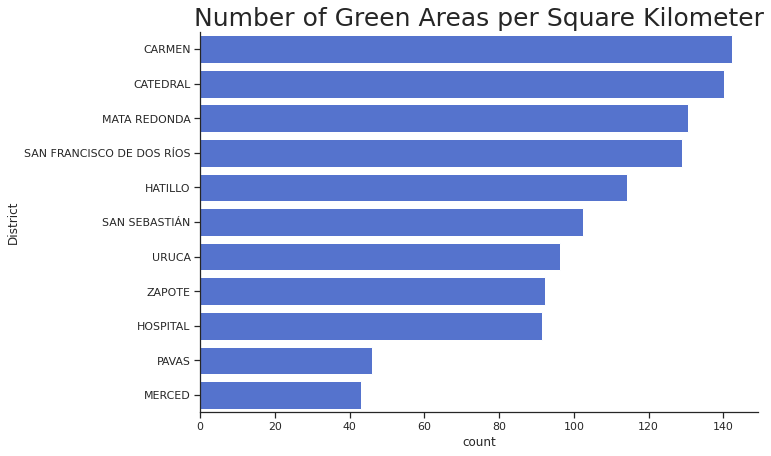

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=type_of_green_area, 
            x='g_areas_per_km2', 
            y='Nombre', 
            color='royalblue'
            )

plt.title('Number of Green Areas per Square Kilometer', fontsize=25)
plt.xlabel('count')
plt.ylabel('District')
plt.show()

Carmen and Catedral are the districts with the most green areas per square kilometer of area. Pavas and Merced are the ones with the least.

**f) How many police stations are there in San Jose?**

In [ ]:
# Count the number of security buildings per type
type_of_security = zoning_data['arcGIS_security']['ABREVIADO'].value_counts().reset_index()

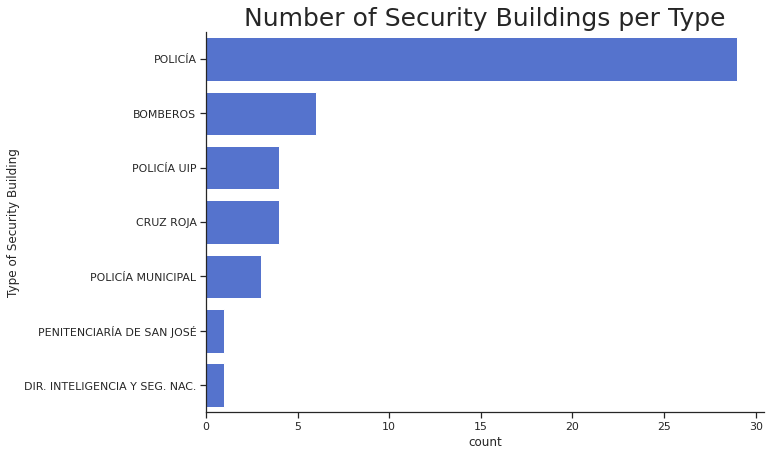

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=type_of_security, 
            x='ABREVIADO', 
            y='index', 
            color='royalblue',
            order=zoning_data['arcGIS_security']['ABREVIADO'].value_counts().index
            )

plt.title('Number of Security Buildings per Type', fontsize=25)
plt.xlabel('count')
plt.ylabel('Type of Security Building')
plt.show()

We can see the security buildings in the city are mainly police-related (Police, Police Intervention Units, City Police). There are also (in the order of most to least common) firefighters, Red Cross, San Jose Jail and Intelligence and National Security Directorate buildings.

**Main conclusions from Section 5.1:**
- It seems as the "public areas" and "green areas" in San Jose are similar (and maybe almost interchangeable). These have roughly the same subcategories (i.e., sports and recreational areas, park, spaces with trees, children playgrounds, squares and plazas, etc).
- The top-3 districts with the most public areas (per km2) is the same as the one for green areas: Carmen in first, Catedral in second, and Mata Redonda in third. The 3 with the least areas is almost the same as well, with districts like Hospital, Merced, and Pavas.
- The majority of public areas in the San Jose canton are owned either by the State or by the City Council, and there are several police stations (most common security building).

#### 5.2) District Characterization

We want to get some knowledge on each of the San Jose's districts, to understand some of their main socioeconomic characteristics. To do so, we are going to check:
- Crime rate
- Social Development Index
- Population density
- Social security

In [ ]:
# Get back the name of the districts as a column
district_sj = district_sj.reset_index()

**a) What are the districts with the highest crime rate per 10k inhabitants?**

We considered the 6 types of crimes available in the dataset: assaults, intentional homicides, theft, robbery, vehicle theft, and rape.

In [ ]:
# Get a variable with a rate for all crimes
district_sj['crime_rate_10k'] = \
district_sj['Tasa de Asaltos por cada 10 mil habitantes'] + \
district_sj['Tasa de Homicidios dolosos por cada 10 mil habitantes'] + \
district_sj['Tasa de Hurtos por cada 10 mil habitantes'] + \
district_sj['Tasa de Robos por cada 10 mil habitantes'] + \
district_sj['Tasa de Robo de vehículos por cada 10 mil habitantes'] + \
district_sj['Tasa de Violaciones por cada 10 mil habitantes']

In [ ]:
# Get needed data
crime_rate_10k = district_sj[['distrito', 'crime_rate_10k']].sort_values(by='crime_rate_10k', ascending=False)

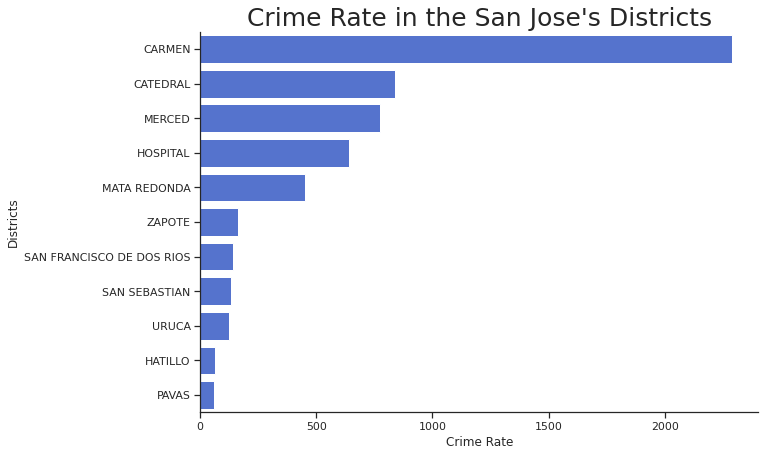

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=crime_rate_10k, 
            x='crime_rate_10k', 
            y='distrito', 
            color='royalblue',
            )

plt.title('Crime Rate in the San Jose\'s Districts', fontsize=25)
plt.xlabel('Crime Rate')
plt.ylabel('Districts')
plt.show()

Carmen is clearly the district with the highest crime rate, with some 2 288 crimes per 10k inhabitants in the year 2016. Hatillo and Pavas are the ones with lowest crime rate, with less than 100 crimes per 10k inhabitants.

**b) What is the Social Development Index in each district?**

The Social Development Index is calculated by the Ministry of Planing and Economic Policy of Costa Rica, and is composed by different socieconomic statistics from various public institutions. It is divided in five categories that go from 0 (min) to 100 (max): Citizen participation, Education, Health, Security and Economy.

In [ ]:
# Get needed data
sdi = district_sj[['distrito', 'IDS 2017']].sort_values(by='IDS 2017', ascending=False)

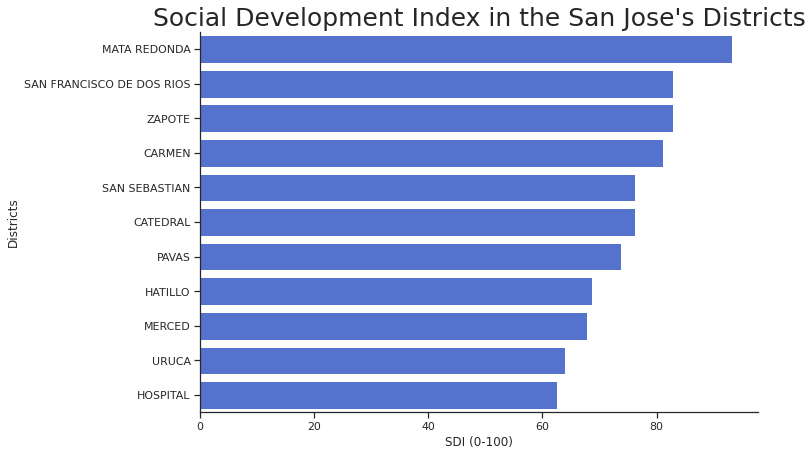

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=sdi, 
            x='IDS 2017', 
            y='distrito', 
            color='royalblue',
            )

plt.title('Social Development Index in the San Jose\'s Districts', fontsize=25)
plt.xlabel('SDI (0-100)')
plt.ylabel('Districts')
plt.show()

We can now compare the 11 districts by their SDI [11]: Mata Redonda is the most developed district (almost max points), and Uruca and Hospital are the least developed (lowest indices, around 65 points).

**c) What is the population density in each district?**

In [ ]:
# Get needed data
pop_density = district_sj[['distrito', 'Densidad de población']].sort_values(by='Densidad de población', ascending=False)

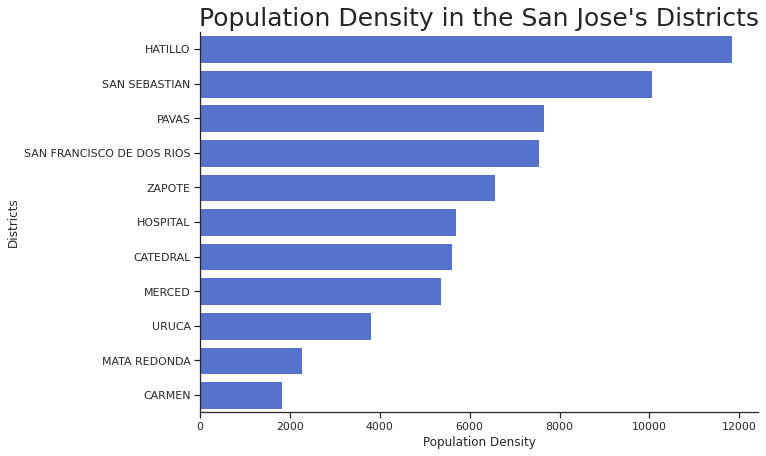

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=pop_density, 
            x='Densidad de población', 
            y='distrito', 
            color='royalblue',
            )

plt.title('Population Density in the San Jose\'s Districts', fontsize=25)
plt.xlabel('Population Density')
plt.ylabel('Districts')
plt.show()

Hatillo and San Sebastian are most densely populated districts in San Jose, with more than 10 000 inhabitants per square kilometer.

Mata Redonda and Carmen, on the other hand, are the least densely populated districts, with around 2 000 inhabitants per square kilometer.

**d) What is the % of people without social security in each district?**

In [ ]:
# Get needed data
social_sec = district_sj[['distrito', 'Porcentaje de población no asegurada']]\
                    .sort_values(by='Porcentaje de población no asegurada', ascending=False)

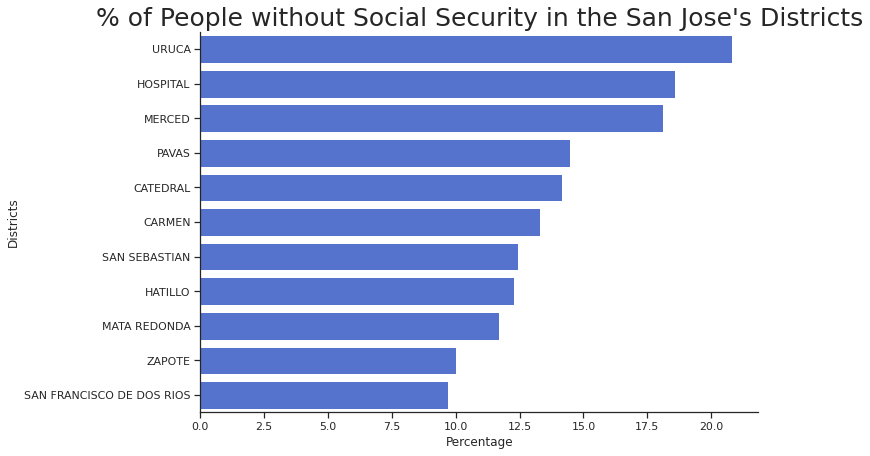

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=social_sec, 
            x='Porcentaje de población no asegurada', 
            y='distrito', 
            color='royalblue',
            )

plt.title('% of People without Social Security in the San Jose\'s Districts', fontsize=25)
plt.xlabel('Percentage')
plt.ylabel('Districts')
plt.show()

Uruca, Hospital and Merced are have around 20% of people without social security.

On the other hand, Zapote and San Francisco de Dos Rios have only around 10% of people in this situation.

**Main conclusions from Section 5.2:**
- Carmen is the district with the lowest population density and the highest crime rate. Hatillo is the most densely populated district and the one with the lowest crime rate. Thus, this might indicate population density is important to understand the districts' crime rates.
- Mata Redonda is one of the least densely populated districts, but it is the most developed according to the SDI.
- Uruca and Hospital are some of the least developed districts, and they have the highest % of people without social security.


#### 5.3) Crimes Against Women in San Jose

In this section we will analyze some charts about the crimes in San Jose (canton) where women are the victim. To do this, we will use the crime records we have for San Jose (2010-2022).

In [ ]:
# Filter the crimes in the canton of San Jose to get only the ones where the victim was female
crimes_san_jose_women = crimes_san_jose[crimes_san_jose['Gender'] == 'female']

**a) What are the most common crimes against women?**

In [ ]:
# Get a table with the most common crimes
most_common_crimes = crimes_san_jose_women['Crime'].value_counts().reset_index()

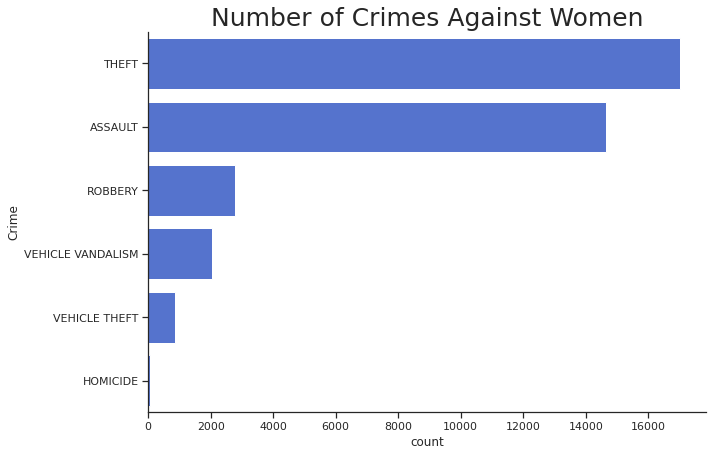

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=most_common_crimes, 
            x='Crime', 
            y='index', 
            color='royalblue',
            )

plt.title('Number of Crimes Against Women', fontsize=25)
plt.xlabel('count')
plt.ylabel('Crime')
plt.show()

The most common crimes in San Jose are theft (pickpocketing, due to neglect, due to trust, deceit/distraction) and assault (firearm, outburst, cold weapon, hitting). 17 004 thefts and 14 647 assaults were registered.

The least common is homicide. 67 were registered in 12 years. Some of these are due to domestic violence and femicide.

Other registered crimes include robbery, vehicle vandalism and vehicle theft.

**b) What is the distribution of crimes per time of day, trimester and year?**

In [ ]:
# Get the trimester on each date
crimes_san_jose_women['Trimester'] = crimes_san_jose_women['Date'].dt.quarter

# Get the year on each date
crimes_san_jose_women['Year'] = crimes_san_jose_women['Date'].dt.year

In [ ]:
# Get a table with the % of crimes per time of day
time_crime = crimes_san_jose_women['Time'].value_counts(normalize=True).reset_index().sort_values('index')
time_crime['Time'] = time_crime['Time']*100

# Get a table with the % of crimes per trimester
trimester_crime = crimes_san_jose_women['Trimester'].value_counts(normalize=True).reset_index().sort_values('index')
trimester_crime['Trimester'] = trimester_crime['Trimester']*100
trimester_crime['index'] = ['T1 (Jan, Feb, Mar)', 
                            'T2 (Apr, May, June)', 
                            'T3 (July, Aug, Sept)', 
                            'T4 (Oct, Nov, Dec)']

# Get a table with the % of crimes per year
year_crime = crimes_san_jose_women['Year'].value_counts(normalize=True).reset_index().sort_values('index')
year_crime['Year'] = year_crime['Year']*100

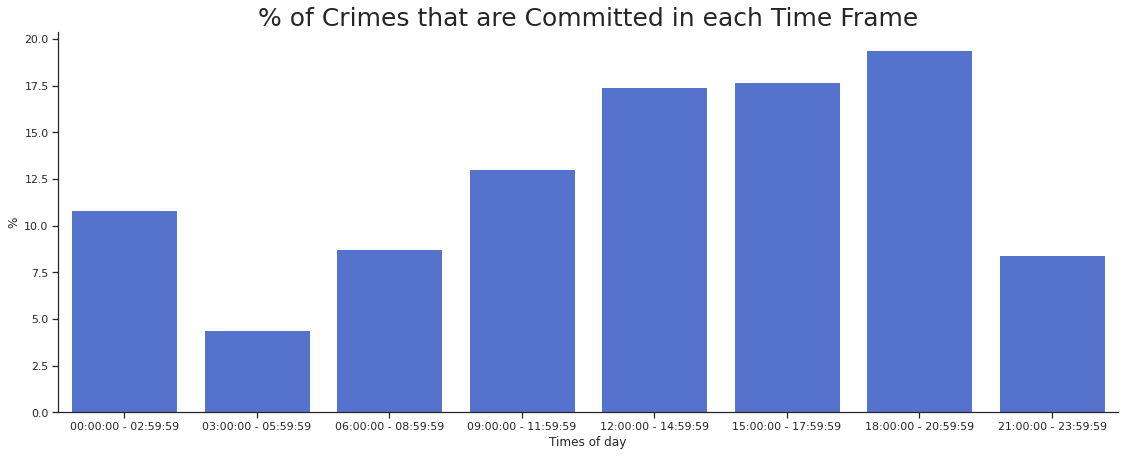

In [ ]:
# Make barplot
plt.figure(figsize=(19, 7))

sns.barplot(data=time_crime, 
            x='index', 
            y='Time', 
            color='royalblue',
            )

plt.title('% of Crimes that are Committed in each Time Frame', fontsize=25)
plt.xlabel('Times of day')
plt.ylabel('%')
plt.show()

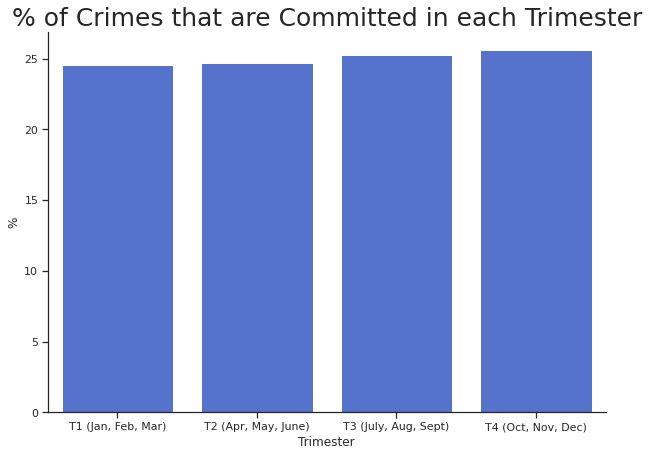

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=trimester_crime, 
            x='index', 
            y='Trimester', 
            color='royalblue',
            )

plt.title('% of Crimes that are Committed in each Trimester', fontsize=25)
plt.xlabel('Trimester')
plt.ylabel('%')
plt.show()

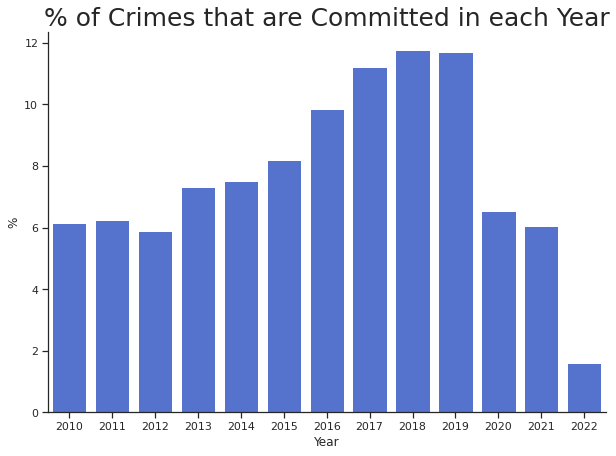

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=year_crime, 
            x='index', 
            y='Year', 
            color='royalblue',
            )

plt.title('% of Crimes that are Committed in each Year', fontsize=25)
plt.xlabel('Year')
plt.ylabel('%')
plt.show()

Time of day: 68% of crimes against women happen during the day or evening, between 9am and 9pm. Still, we can see there are some crimes being committed in the frame 9pm-9am, during the night, specially between midnight and 3am.

Trimester: The trimesters seem to have roughly the same % of crimes against women.

Year: It seems the number of crimes was somewhat increasing until 2019. From 2020 on, the crimes against women seem to be declining. This is likely very influenced by the lockdowns imposed due to the COVID-19 pandemic. 

**c) What are the top-10 most common types of victim?**

In [ ]:
print('\033[1mTop-10 Most Common Types of Victim:\n\033[0m')
crimes_san_jose_women['SubtypeVictim'].value_counts(normalize=True).head(10)

Top-10 Most Common Types of Victim:



PEDESTRIAN [PERSON]                                     0.404652
NOT APPLICEABLE [HOUSING]                               0.090790
CAR [VEHICLE]                                           0.087288
CUSTOMER LOCAL STORE [PERSON]                           0.083625
PASSENGER OF PUBLIC TRANSPORT [PERSON]                  0.074081
OTHER OR UNDETERMINED [PERSON]                          0.046010
USER OF PUBLIC OR PRIVATE TRANSPORT SERVICE [PERSON]    0.026146
OFFICES/COMPANY BUILDING [BUILDING]                     0.023767
RURAL 4X4 [VEHICULE]                                    0.019115
STORE/BOUTIQUE [BUILDING]                               0.015105
Name: SubtypeVictim, dtype: float64

Almost half of the female victims are pedestrians on the street or public/green spaces. Some are in cars or public transport. Others are also in their homes or in company offices, among others.

**d) What are the most common victim's age categories?**

In [ ]:
# Get the number of crimes 
ages = crimes_san_jose_women['Age'].value_counts().reset_index()
ages['index'] = ['>18', '>60', '<18', 'Unknown']

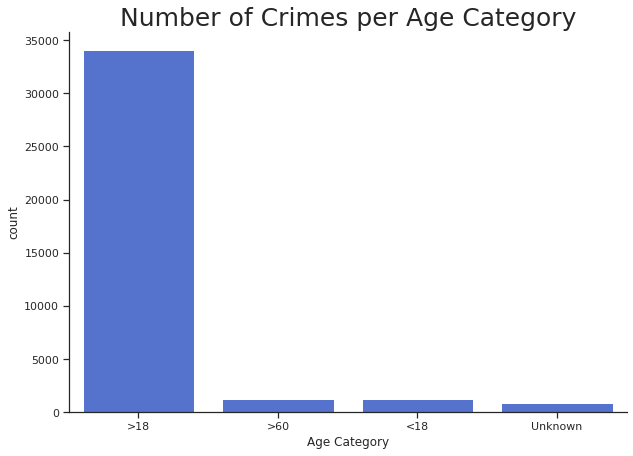

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

sns.barplot(data=ages, 
            x='index', 
            y='Age', 
            color='royalblue',
            )

plt.title('Number of Crimes per Age Category', fontsize=25)
plt.xlabel('Age Category')
plt.ylabel('count')
plt.show()

This variable does not seem to store valuable information, because it only says the vast majority of victims are adults, while a very small number are elder (3.4%), girls (3.2%) or of unknown age (2.2%).

**e) How are the crimes distributed in each San Jose district?**

In [ ]:
# Get the number of crimes per district
crimes_per_district = crimes_san_jose_women[['District', 'Crime']].groupby(['District', 'Crime']).size().reset_index()
crimes_per_district = pd.pivot_table(crimes_per_district, 
                                     values=0, 
                                     index='District', 
                                     columns='Crime')

In [ ]:
# Sort columns
s = crimes_per_district.sum()
crimes_per_district = crimes_per_district[s.sort_values(ascending=False).index[:]]

# Sort rows
crimes_per_district = crimes_per_district\
                              .assign(sum=crimes_per_district.sum(axis=1))\
                              .sort_values(by='sum', ascending=False)\
                              .drop(columns='sum')

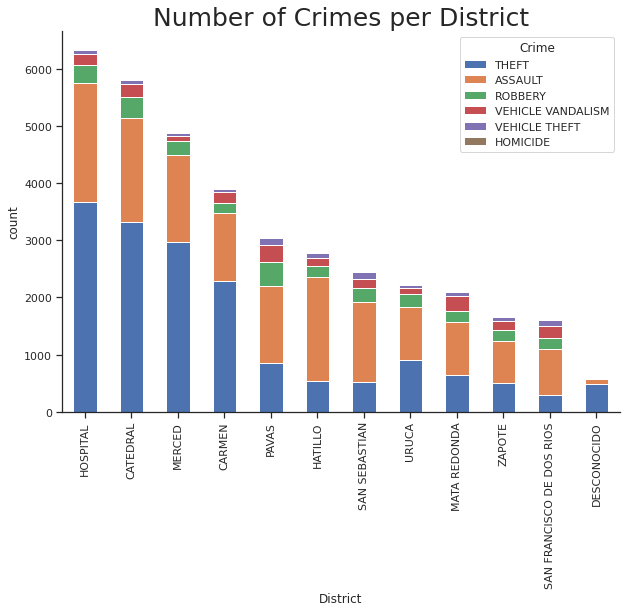

In [ ]:
# Make stacked bar chart
crimes_per_district.plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Number of Crimes per District', fontsize=25)
plt.xlabel('District')
plt.ylabel('count')
plt.show()

The top-3 districts with the most crimes are Hospital, Catedral and Merced. The top-3 with the least are Mata Redonda, Zapote and San Francisco de Dos Rios (excluding "DESCONOCIDO", which means "Unknown").

We can see that in the 11 districts, there are two main crimes being committed to women, which are theft and assault:
- Women are more frequently stolen from ("theft") in these districts: Carmen, Catedral, Hospital, and Merced.
- And they are more frequently assaulted ("assault") in these districts: Hatillo, Mata Redonda, Pavas, San Francisco de Dos Rios, San Sebastian, Uruca, and Zapote.

As for the other four types of crime, they can generally be ordered from *most common* to *least common* as: robbery, vehicle vandalism, vehicle theft, and homicide. The highest number of homicides was recorded in Pavas, and the lowest in Zapote.

**Main conclusions from Section 5.3:**
- Variables that seem to influence crime against women: time of the day (most crimes happen between 12pm-9pm) and year (2018 and 2019 had many crimes, but from 2020 on they reduced).
- Variables that *do not* seem to influence it: trimester (all 4 trimesters have basically the same % of crimes), type of victim (almost 100% of victims are pedestrians, so this feature is not that meaningful) and age category (once again, almost 100% of victims are adults, so this feature is also not that meaningful).
- Conclusions about the districts: we checked if the top-3 districts with the most crimes against women would be the most densely populated, but that does not happen (Hospital, Catedral and Merced have an average population density). Still, we should at least pay attention to the populations in the next Sections.

#### 5.4) Street Harassment in San Jose

In this section we will analyze the distribution of street harassment crimes by district of San Jose.

In [ ]:
# Get the total number of street harassment reports per district
street_canton['total'] = \
street_canton['sexual_harassement'] + \
street_canton['exhibitionism'] + \
street_canton['pursuit_or_cornering'] + \
street_canton['production_of_audiovisual_material'] + \
street_canton['sexual_harassement_law']

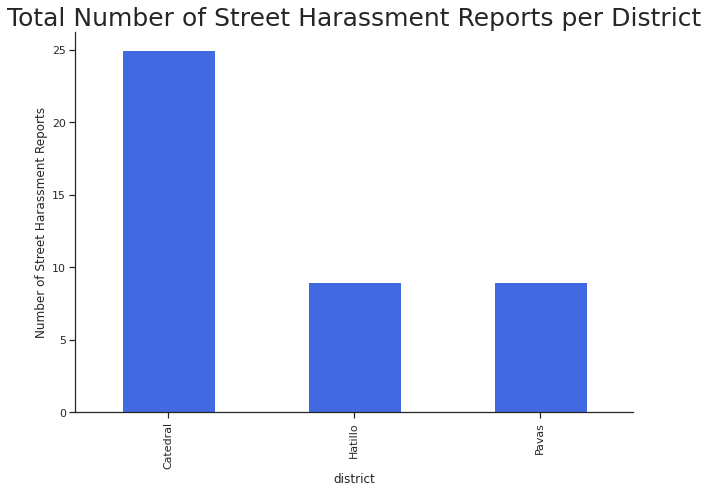

In [ ]:
# Make barplot
plt.figure(figsize=(10, 7))

ax = street_canton['total'].plot(kind='bar', color='royalblue')

ax.set_title('Total Number of Street Harassment Reports per District', fontsize=25)
ax.set_ylabel('Number of Street Harassment Reports')
plt.show()

**Main conclusions from Section 5.4:**
- For the canton of San Jose, we only have street harassment crimes data for 3 districts (out of 11), in 2021. From these, we can see that the **Catedral district is the one with the highest number of reported crimes.**
- Due to the small coverage of the San Jose districts, **we decided not to use this dataset in the remaining analysis.**

#### 5.5) Park and Transit Stations Reviews in San Jose

Plot to check the **distribution** of Ratings:

```
# Get the number of Google ratings per point (1-5)
park_ratings = park_df['result.rating'].dropna().astype(int).value_counts().sort_index()
park_ratings[1] = 0
park_ratings = park_ratings.sort_index()

transit_ratings = transit_df['result.rating'].dropna().astype(int).value_counts().sort_index()
```

```
# Make plot
groups = transit_ratings.index

fig = go.Figure(data=[
    go.Bar(name='Park', x=groups, y=park_ratings.values, marker_color='green'),
    go.Bar(name='Transit', x=groups, y=transit_ratings.values, marker_color='grey')
])

# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(yaxis_title='Frequency', xaxis_title='Ratings')

fig.show()
```

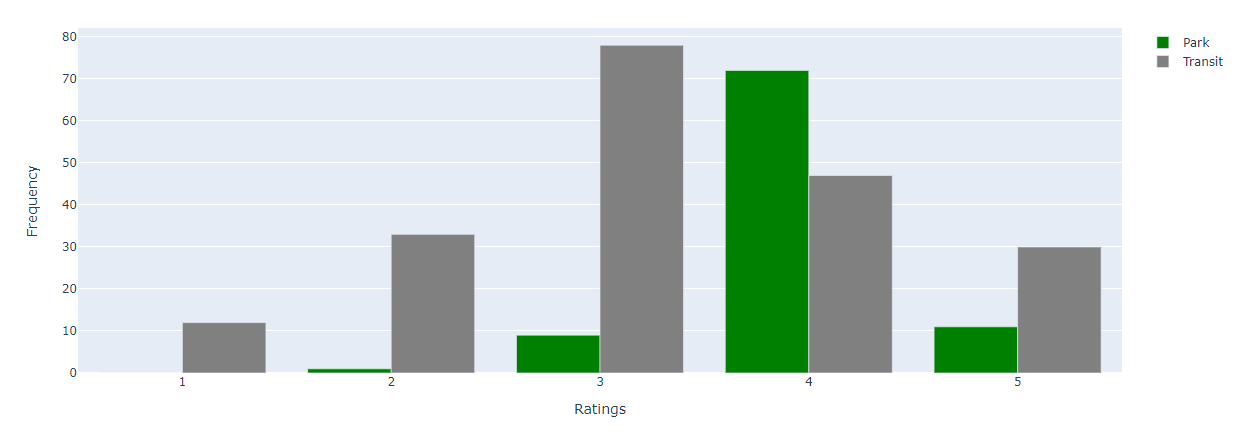

In [140]:
from IPython.display import Image
Image(filename=path + '/images/ratings_chart.png')

In [ ]:
print('For the Parks:')
print(f'Most Ratings are between 4 and 5 Stars. There are only {park_ratings[2]} rating with 2 Stars and {park_ratings[3]} with 3 Stars.')
median_5 = park_df['median'].value_counts()[5]
print(f'If we consider the Median ratings as a metric, then {median_5} out of {len(park_df)} parks have 5 Stars.')
print('This shows that Parks in San Jose have good reviews, and they are probably safe.')

print('')

print('For the Transit Stations:')
print(f'The Ratings are worse than the ones for Parks, with a total of {transit_ratings[3]} ratings evaluated as 3.')
print(f'There are even {transit_ratings[1]} 1-Star ratings.')
comment = transit_df[transit_df['result.rating']==1].iloc[2]['text']
print(f'With a quick search on the reviews with 1-Star ratings, we can find this: "{comment}"')
print('This shows that the bus stations in San Jose may need changes to improve security.')

For the Parks:
Most Ratings are between 4 and 5 Stars. There are only 1 rating with 2 Stars and 9 with 3 Stars.
If we consider the Median ratings as a metric, then 62 out of 127 parks have 5 Stars.
This shows that Parks in San Jose have good reviews, and they are probably safe.

For the Transit Stations:
The Ratings are worse than the ones for Parks, with a total of 78 ratings evaluated as 3.
There are even 12 1-Star ratings.
With a quick search on the reviews with 1-Star ratings, we can find this: "A somewhat dangerous area, especially at night."
This shows that the bus stations in San Jose may need changes to improve security.


 WordCloud for the **Park** Ratings:

In [ ]:
# Concatenate all the text after removing STOP WORDS
all_text = park_df['text'].dropna().values
stop_words = set(stopwords.words('english'))
Words = list()

for text in all_text:
    if text == '':
        pass
    else:
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
        Words.append(filtered_sentence)

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

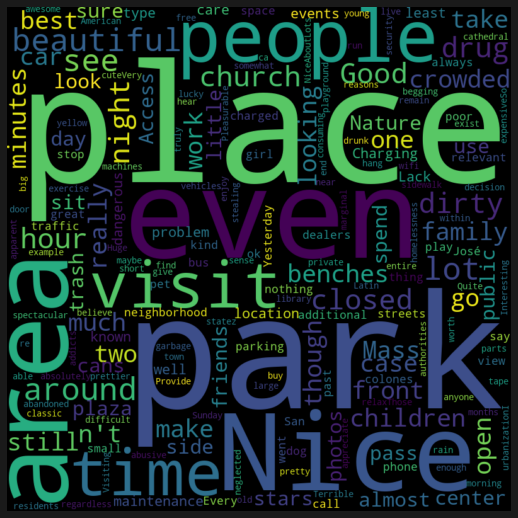

In [ ]:
# Create word cloud for the text with 3 Stars or Less
text = flatten(Words)
text = " ".join(text)
wordcloud = WordCloud(width=800, height=800, margin=0).generate(text)

# Display the generated image
plt.figure(figsize=(7,7), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(pad=0)
plt.show()

 WordCloud for the **Transit Stations** Ratings:

In [ ]:
# Concatenate all the text after removing STOP WORDS
all_text = transit_df['text'].dropna().values
stop_words = set(stopwords.words('english'))
Words = list()

for text in all_text:
    if text == '':
        pass
    else:
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
        Words.append(filtered_sentence)

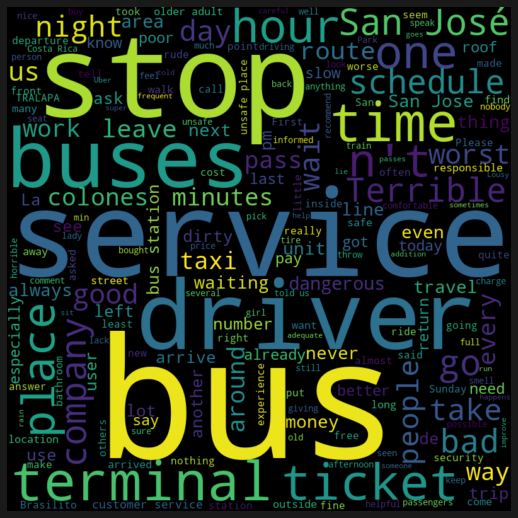

In [ ]:
# Create word cloud for the text with 3 Stars or Less
text = flatten(Words)
text = " ".join(text)
wordcloud = WordCloud(width=800, height=800, margin=0).generate(text)

# Display the generated image
plt.figure(figsize=(7,7), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(pad=0)
plt.show()

**Main conclusions from Section 5.5:**
- We can see the transit stations have generally less favorable ratings when compared to the parks.
- On the word cloud for transit stations we can see words like "terrible", "dangerous" and "unsafe", which indicates these public stations migh be insecure. In the parks word cloud, it seems like the words that represent insecurity are less frequent.  

### 6. Time Series





#### 6.1) Create dataset 

In this section, we will build the 4 time series under analysis. 

By trimester and year, for the 2 most representative districts of the canton of San Jose.

In [ ]:
print('Number of crimes between 2010 and 2022')

for dist in crimes_san_jose_women['District'].unique():
    dimension = crimes_san_jose_women.loc[crimes_san_jose_women['District']==dist].shape[0]
    print(f'{dist}: {dimension}')

Number of crimes between 2010 and 2022
HOSPITAL: 6340
PAVAS: 3054
MERCED: 4879
SAN SEBASTIAN: 2448
HATILLO: 2788
URUCA: 2230
CATEDRAL: 5817
MATA REDONDA: 2091
CARMEN: 3899
SAN FRANCISCO DE DOS RIOS: 1603
ZAPOTE: 1658
DESCONOCIDO: 598


Since the districts of **Hospital** and **Catedral** have the highest number of crimes between 2010 and 2022, we will proceed with the analysis of the two, predicting the security index for both and charaterizing them in terms of their **socioeconomic features**.

To build the time series, we need the *get_ts_trimester* and *get_ts_year* functions, which are both in **Appendix B**.

In [ ]:
# Filter crimes done in the Hospital district
hospital = crimes_san_jose_women.loc[crimes_san_jose_women['District']=='HOSPITAL']

# Get Hospital time series by trimester
ts_hospital_trim = get_ts_trimester(hospital)

# Get Hospital time series by year
ts_hospital_year = get_ts_year(hospital)

In [ ]:
# Filter crimes done in the Catedral district
catedral = crimes_san_jose_women.loc[crimes_san_jose_women['District']=='CATEDRAL']

# Get Catedral time series by trimester
ts_catedral_trim = get_ts_trimester(catedral)

# Get Catedral time series by year
ts_catedral_year = get_ts_year(catedral)

In [ ]:
ts_hospital_trim.head()

TOTAL_CRIMES  00:00:00 - 02:59:59  06:00:00 - 08:59:59  \
Year Trimester                                                           
2010 1                    65                  3.0                  9.0   
     2                    83                  8.0                  6.0   
     3                    84                  9.0                  5.0   
     4                    78                  8.0                  4.0   
2011 1                    88                  9.0                  6.0   

                09:00:00 - 11:59:59  12:00:00 - 14:59:59  15:00:00 - 17:59:59  \
Year Trimester                                                                  
2010 1                         10.0                  8.0                  9.0   
     2                         14.0                 17.0                 14.0   
     3                         18.0                 16.0                 18.0   
     4                         11.0                 17.0                 16.0   
2011 1                         12.0                 15.0                 20.0   

                18:00:00 - 20:59:59  21:00:00 - 23:59:59  03:00:00 - 05:59:59  \
Year Trimester                                                                  
2010 1                         19.0                  7.0                  0.0   
     2                         17.0                  4.0                  3.0   
     3                         15.0                  3.0                  0.0   
     4                         19.0                  1.0                  2.0   
2011 1                         13.0                  8.0                  5.0   

                PEDESTRIAN [PERSON]  >18 y/o  
Year Trimester                                
2010 1                         30.0     62.0  
     2                         35.0     79.0  
     3                         38.0     80.0  
     4                         36.0     76.0  
2011 1                         39.0     84.0

In [ ]:
# Build final Hospital dataset
ts_hospital_trim = ts_hospital_trim.reset_index()
ts_hospital_trim['Year'] = ts_hospital_trim['Year'].astype(str)
ts_hospital_trim['Trimester'] = ts_hospital_trim['Trimester'].astype(str)
ts_hospital_trim['Year - Trimester'] = ts_hospital_trim['Year'] + ' - T' + ts_hospital_trim['Trimester']
ts_hospital_trim = ts_hospital_trim.drop(columns=['Year', 'Trimester']).set_index('Year - Trimester')

#### 6.2) Analysis

We decided to explore one of the used time series. In this case, we will analyse the evolution of crimes against women by trimester for Hospital, which is the district with the most crimes.

We start with a **line plot** to show the evolution of the time series over all trimesters. The main insights taken from this plot are that:
- the trimester with the most crimes seems to be always in the year 2018 (sometimes it also is in 2019) 
- the series do not have any missing values, and it seems they also do not have outliers
- it seems like, in general, there are up and downtrends on these time series; in terms of pattern most seem to be non-stationary, but we will need to apply tests to confirm or deny this hypothesis

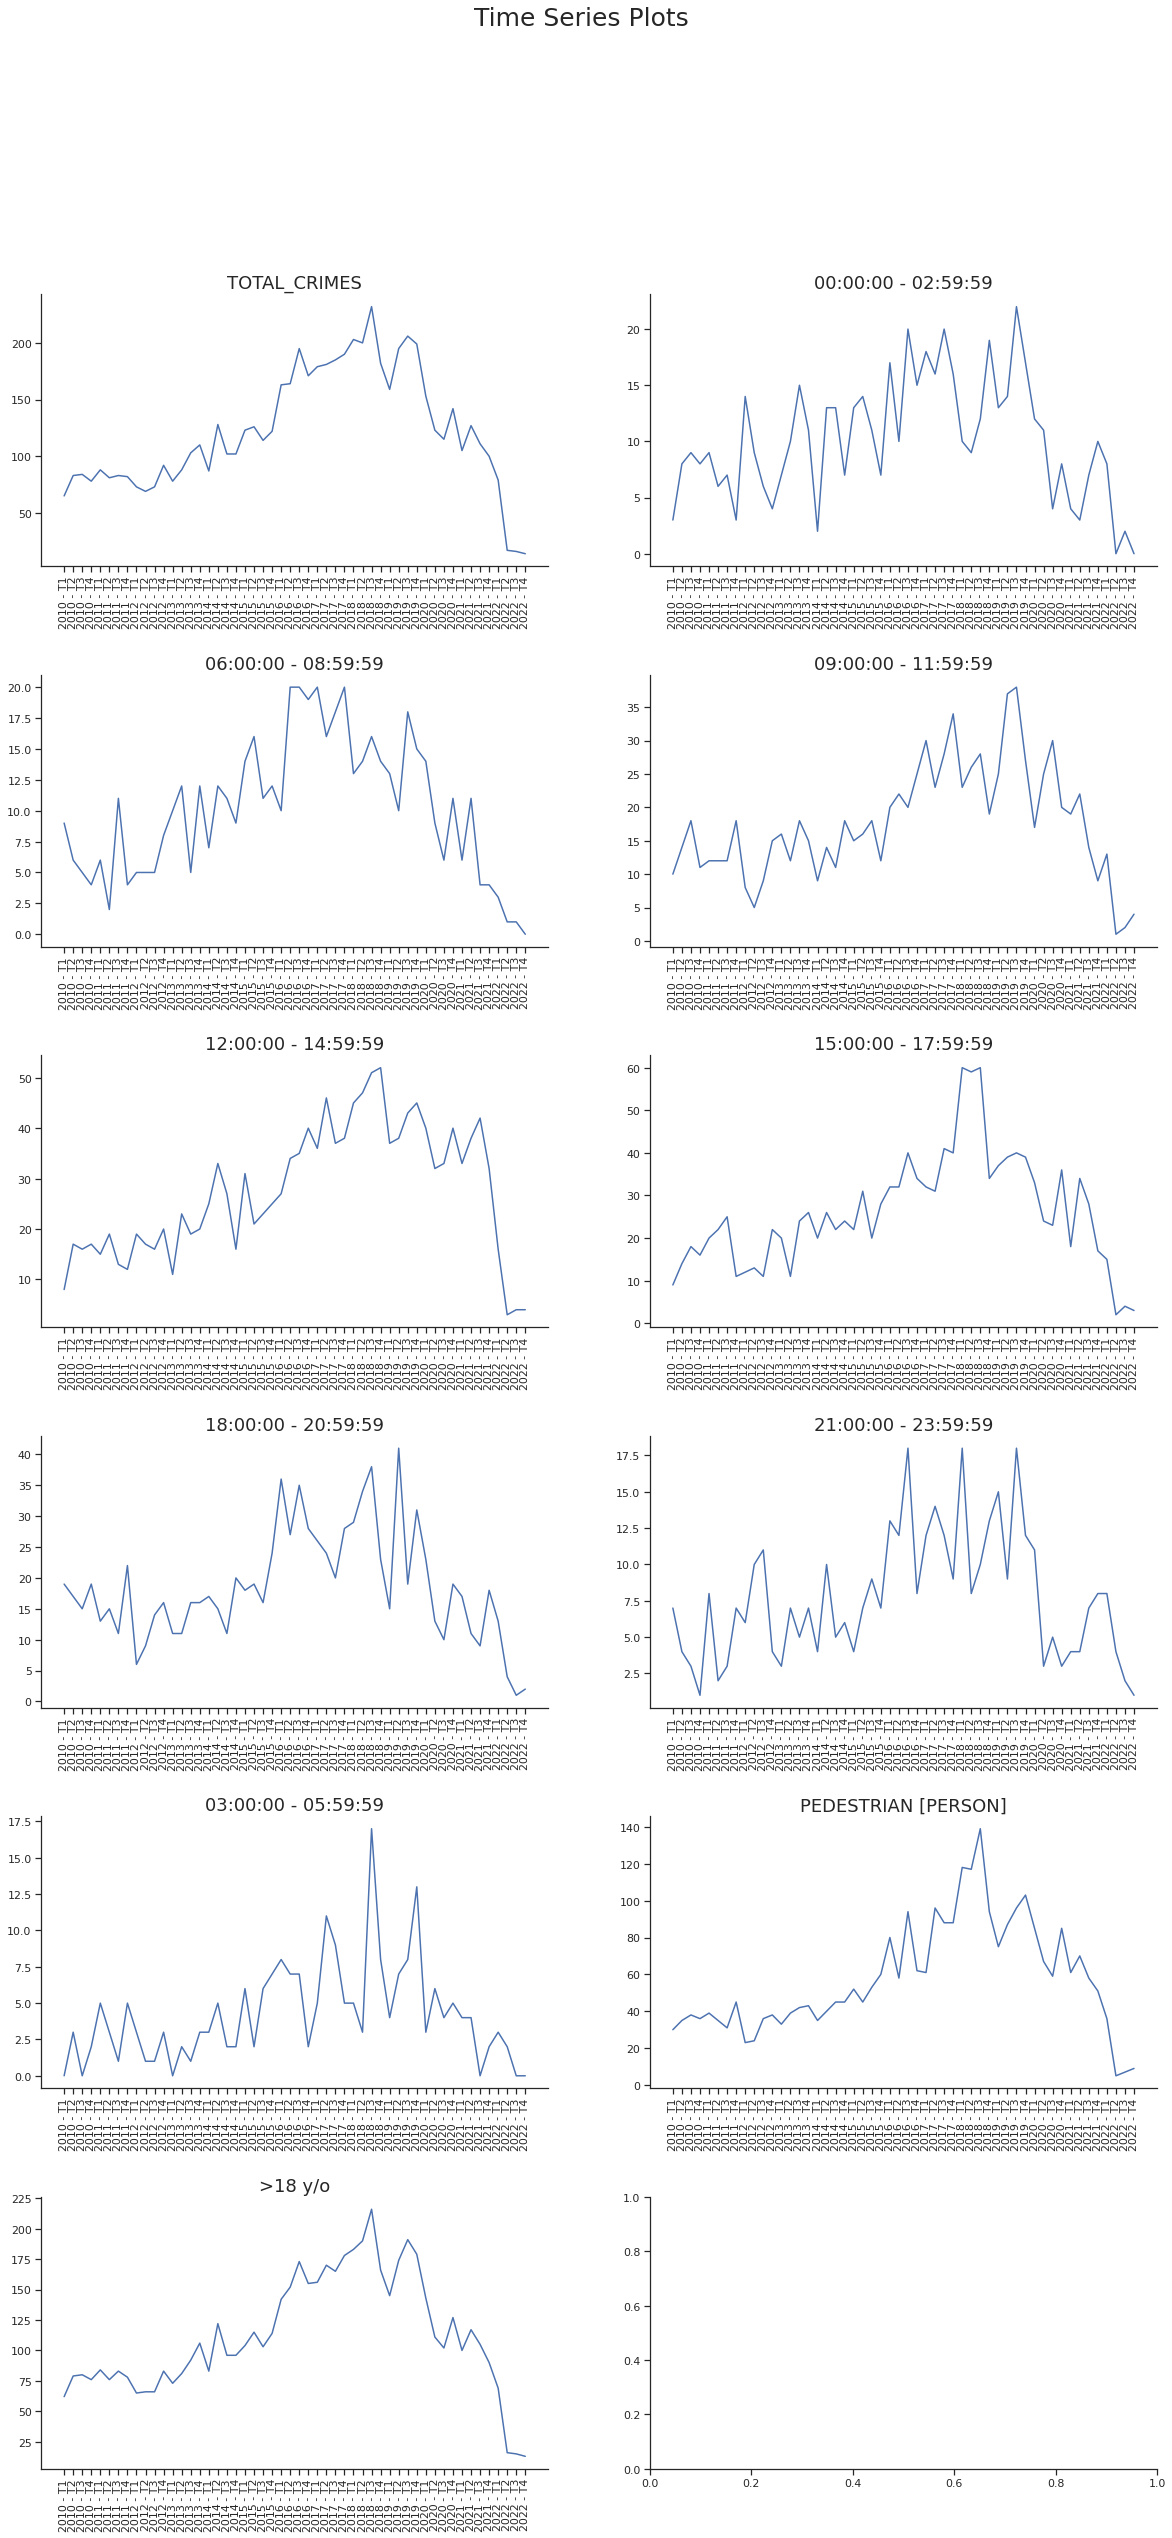

In [ ]:
# Create individual axes 
fig, axes = plt.subplots(ceil(len(ts_hospital_trim.columns)/2), 2, figsize=(20, 40))
plt.subplots_adjust(hspace = 0.4)

# Increase the font size on each title
font = {'size': 18}

# Plot data
for ax, feat in zip(axes.flatten(), ts_hospital_trim.columns):
    ax.plot(ts_hospital_trim[feat], '-')
    ax.set_title(feat, fontdict = font)
    ax.tick_params(axis='x', labelrotation=90)
    
# Title
plt.suptitle("Time Series Plots", fontsize=25)
  
plt.show()

Next we show **box plots**. The main insights taken from this plot are:
- once again, it seems like there are no extreme values
- the box plots are close to a normal distribution
- many variables seem to be very similar in terms of distribution, so they are probably correlated

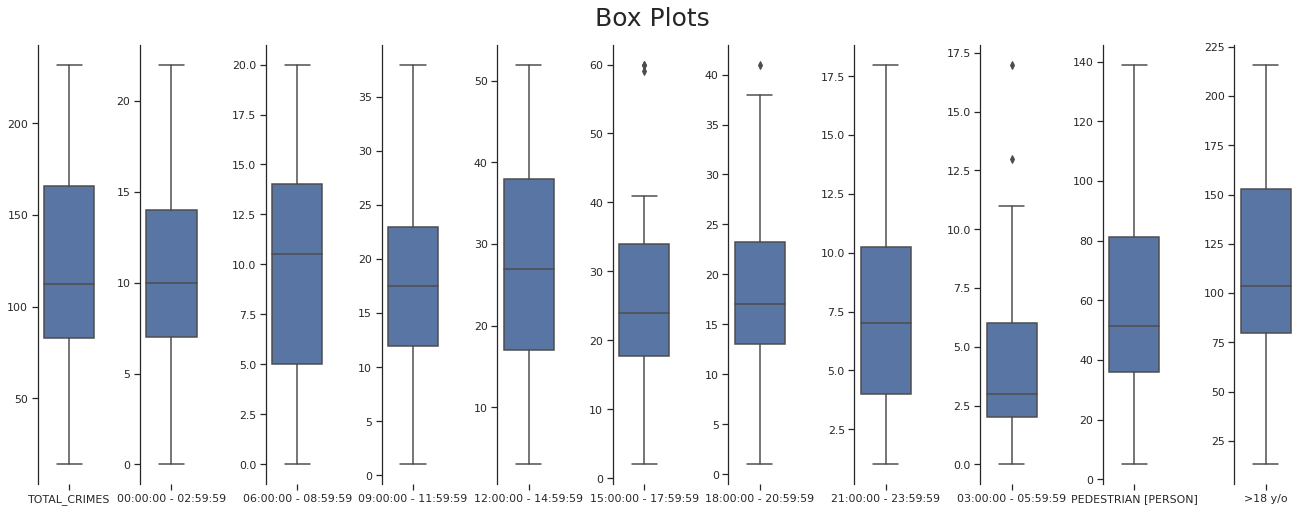

In [ ]:
# Prepare dataframe layout
data = pd.melt(ts_hospital_trim.reset_index(), 
               id_vars=['Year - Trimester'], 
               value_vars=list(ts_hospital_trim.columns)).set_index('Year - Trimester')
plot_features = list(ts_hospital_trim.columns)

# Prepare figure layout
fig, axes = plt.subplots(1, len(plot_features), figsize=(18,7), constrained_layout=True)

# Draw the boxplots
for i in zip(axes, plot_features):
    sns.boxplot(x="variable", y="value", data=data.loc[data["variable"]==i[1]], ax=i[0])
    i[0].set_xlabel("")
    i[0].set_ylabel("")

# Finalize the plot
plt.suptitle("Box Plots", fontsize=25)
sns.despine(bottom=True)

plt.show()

Next we show the **correlation matrix**, calculated with the *Pearson correlation coefficient*. The main insights taken from this plot are:
- most variables are positively correlated, which highlights the fact that the variables tend to move in the same direction
- some correlations are above 0.9 (very high positive correlation)
- no correlations seem to be low or negative

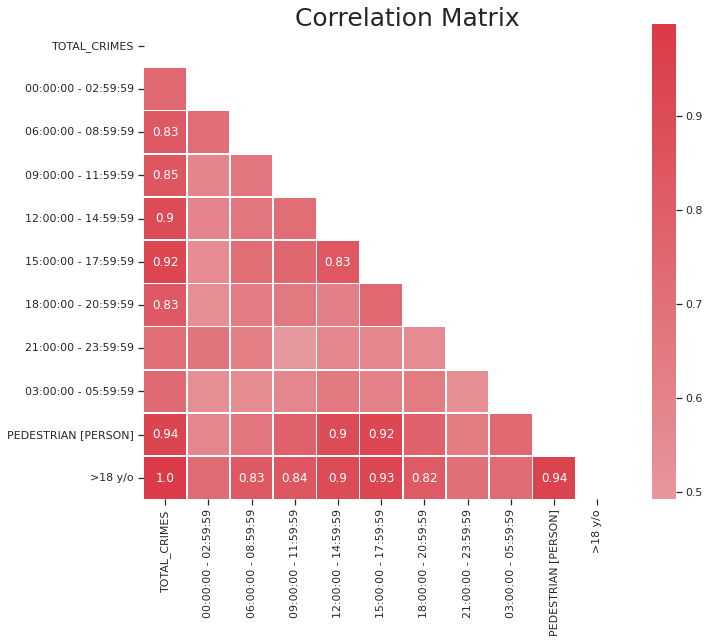

In [ ]:
# Compute the correlation matrix
corr = ts_hospital_trim.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) # Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True # The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Pass 2D Numpy array to annot parameter
size = len(plot_features)
mask_annot = (np.absolute(corr.values)>=0.80) | (np.absolute(corr.values)<=0.05) # Annotate correlations above abs(0.7) or below abs(0.05)
annot_arr = np.where(mask_annot, corr.values.round(2), np.full((size, size), ""))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0, square=True, mask=mask, linewidths=.5, ax=ax, annot=annot_arr, fmt="s")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation Matrix", fontsize=25)
plt.yticks(rotation=0)

plt.show()

#### 6.3) Modelling

We will proceed to build time series models. Our goal is to have a way to predict the number of crimes against women. A predictive model like this is essential for the project.

In terms of **Decomposition and Autocorrelation**, stationarity is essential for a time series to be fed to an ARIMA model. A time series is stationary when mean, variance and co-variance are constant over time.

We also have to guarantee the series is not autocorrelated, meaning the independant variables should be uncorrelated with the precedant time lags.

If a series is not stationary or is autocorrelated, we have ways to deal with it. We can transform the time series with differentiation, so we subtract every value by its precedent.

The *dickey_fuller_plot* function below analyzes a time series' stationarity and autocorrelation. It does it with the Augmented Dickey-Fuller test. This allows us to detect which series are ready to use (stationary and not autocorrelated). And also the ones that need to be transformed.

The function evaluates the null hypothesis that there is autocorrelation, so if p-value is below 0.05 we consider that there is no correlation between the moments. Otherwise, Dickey-Fuller recommends to transform the dataset. Furthermore, we also plot autocorrelation and partial autocorrelation.

In [ ]:
def dickey_fuller_plot(data, variable, lags=8):
    series = data[variable]
    series_dif = (series - series.shift(1))[1:]

    # https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html
    p_value = sm.tsa.stattools.adfuller(series)[1]
    p_value_dif = sm.tsa.stattools.adfuller(series_dif)[1]

    fig = plt.figure(figsize=(12, 7))
    layout = (3,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    acf_ax_dif = plt.subplot2grid(layout, (2,0))
    pacf_ax_dif = plt.subplot2grid(layout, (2,1))
    
    series.plot(ax=ts_ax)
    ts_ax.set_title(f'Time Series Analysis Plots: {variable}\n Dickey-Fuller: p={p_value:.5f}\n DF diff: p={p_value_dif:.5f}')
    smt.graphics.plot_acf(series, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(series, lags=lags, ax=pacf_ax)
    
    smt.graphics.plot_acf(series_dif, lags=lags, ax=acf_ax_dif)
    smt.graphics.plot_pacf(series_dif, lags=lags, ax=pacf_ax_dif)

    plt.tight_layout()

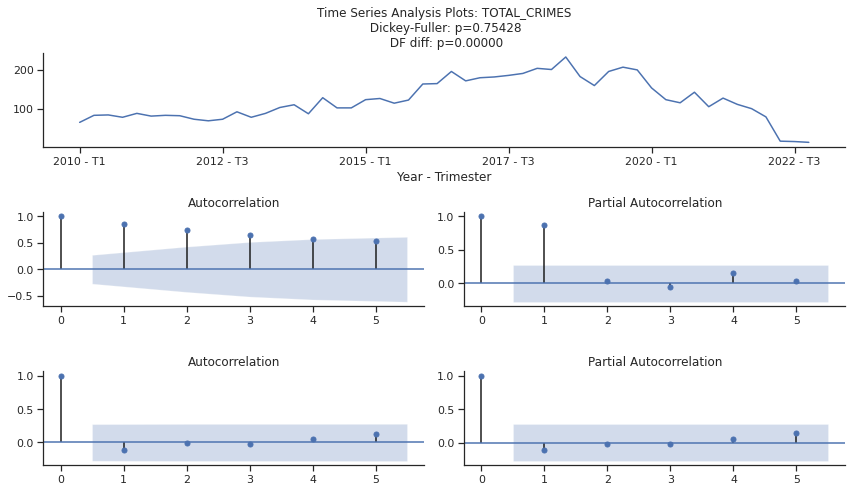

In [ ]:
dickey_fuller_plot(ts_hospital_trim, 'TOTAL_CRIMES', 5)

The outputs above show us the Dickey-Fuller p-value and the correlogram and partial correlogram for the original series (first + second) and for the differenciated series (third + fourth).

The autocorrelation plots consider internal association between observations. The closer to 1 or -1, the highest correlation between lags.

The partial correlogram is a summary of the relationship between an observation in a time series with other prior observation, removing the relationship of observations contained between them.

We checked the four time series under analysis with respect to the Women's Security Index proxy variable that we will use: TOTAL_CRIMES, and concluded that **they are all Non-Stationary**. Thus, we subtracted the previous value of the series to the current value, which makes our series stationary.

The output above shows the results for the Hospital district, by trimester.

In [ ]:
# Differentiation
ts_hospital_trim['TOTAL_CRIMES_SHIFT'] = ts_hospital_trim['TOTAL_CRIMES'] - ts_hospital_trim['TOTAL_CRIMES'].shift(1)
ts_hospital_trim = ts_hospital_trim.dropna()

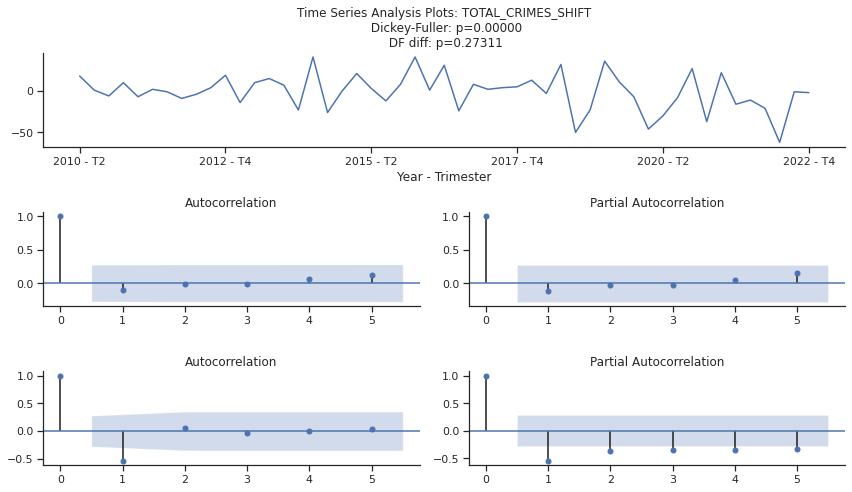

In [ ]:
# Now, the series is stationary
dickey_fuller_plot(ts_hospital_trim, 'TOTAL_CRIMES_SHIFT', 5)

Next, the **Train-Validation Split**. We need to split the dataset between training and validation. We will train the model with data until 2020, and then we validate with the next 2 years, 2021 and 2022.

In [ ]:
# Creating the train and validation set
train_hosp_trim = ts_hospital_trim.loc[:'2020 - T4']
valid_hosp_trim = ts_hospital_trim.loc['2021 - T1':]

As for the **Models**, we tested Autoregressive Integrated Moving Average (ARIMA) models:

a) For the exogenous regressors, we used all variables extracted from the Crimes dataset. As for the observed time-series process, y, we selected the TOTAL_CRIMES_SHIFT variable.

b) We tried to create 4 ARIMA models to predict the total number of crimes per district: two models per trimester and two models per year, in the selected districts. However, the yearly time series only has 12 years under analysis, which is not sufficient to model this data in a correct way, due to the small time span analized. **Thus, we did not perform forecasts for the year period.**

The trimester analysis for the Catedral district is in **Appendix C**.

In [ ]:
model = sm.tsa.ARIMA(endog=train_hosp_trim['TOTAL_CRIMES_SHIFT'], 
                     exog=train_hosp_trim.drop(['TOTAL_CRIMES_SHIFT', 'TOTAL_CRIMES'], axis=1),
                     order=[1,1,1])
results = model.fit()
print(results.summary())

                              ARIMA Model Results                               
Dep. Variable:     D.TOTAL_CRIMES_SHIFT   No. Observations:                   42
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -178.072
Method:                         css-mle   S.D. of innovations             15.926
Date:                  Mon, 23 May 2022   AIC                            384.144
Time:                          20:53:29   BIC                            408.472
Sample:                               1   HQIC                           393.061
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         10.3642      3.817      2.715      0.011       2.883      17.845
00:00:00 - 02:59:59            0.7582      0.971      0.781      0.

ARIMA stands for:
* **AR - Autoregressive:** it is a regression of the variable against itself with a lag p of observations; in an autoregression model, we forecast using a linear combination of past values of the variable
* **I - Integrated:** the use of differencing of raw observations to make the time series stationary
* **MA - Moving Average:** a moving average term in a time series model is a past error (multiplied by a coefficient); uses the dependency between an observation and a residual error from a moving average model applied to lagged observations

Simply put, the autoregression of the residual errors is the moving average model.

The *optimize_ARIMA* function below finds the model with lowest AIC (Akaike Information Critera). It tests several models, changing the order parameters p,d and q. These determine the number of lags for the Autorregresive and Moving Average models (parameters p and q, respectively). d represents the integration parameter, which indicates the number of differentation series needed to reach stationarity.

In [ ]:
# Set initial values and some bounds
p = range(0, 5)
d = 1
q = range(0, 5)

# Create a list with all possible combinations of parameters
parameters = product(p, q)
parameters_list = list(parameters)

In [ ]:
def optimize_ARIMA(parameters_list, endog, exog, d=1):
    """
    We enter a series and the function returns a dataframe with parameters and corresponding AIC
    
    parameters_list - list with (p, q) tuples
    p - AR time laps
    d - integration order
    q - MA time laps

    endog - observed time-series process, y
    
    exog - array of exogenous regressors
    """
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = ARIMA(endog=endog, exog=exog, order=(param[0], d, param[1]))
            model_fit = model.fit(disp=-1)
        except:
            continue
            
        aic = model_fit.aic
        
        # Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model_fit
            best_aic = aic
            best_param = param
        results.append([param, model_fit.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    
    # Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
train_hosp_trim_result = optimize_ARIMA(parameters_list, 
                                        train_hosp_trim['TOTAL_CRIMES_SHIFT'], 
                                        train_hosp_trim.drop(['TOTAL_CRIMES_SHIFT', 'TOTAL_CRIMES'], axis=1))

  0%|          | 0/25 [00:00<?, ?it/s]

According to the outputs below, the function recommends to build an **ARIMA(0, 1, 4)**.

Also, as we saw above the series are all stationary, so d=1.

In [ ]:
train_hosp_trim_result.head()

,parameters,aic
0,"(0, 4)",356.645927
1,"(3, 4)",359.064973
2,"(4, 2)",359.583575
3,"(3, 2)",363.955887
4,"(2, 2)",365.285708


**Model summary:** The vast majority of p-values are equal or under 0.05, so they are statistically significant.

In [ ]:
# Model to predict TOTAL_CRIMES
model = ARIMA(endog=train_hosp_trim['TOTAL_CRIMES_SHIFT'], 
              exog=train_hosp_trim.drop(['TOTAL_CRIMES_SHIFT', 'TOTAL_CRIMES'], axis=1), 
              order=(0,1,4))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

                              ARIMA Model Results                               
Dep. Variable:     D.TOTAL_CRIMES_SHIFT   No. Observations:                   42
Model:                   ARIMA(0, 1, 4)   Log Likelihood                -162.323
Method:                         css-mle   S.D. of innovations             10.008
Date:                  Mon, 23 May 2022   AIC                            356.646
Time:                          21:01:21   BIC                            384.449
Sample:                               1   HQIC                           366.837
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         10.6174      1.521      6.980      0.000       7.636      13.599
00:00:00 - 02:59:59            0.6463      0.308      2.096      0.

The next function represents the forecasts made from our ARIMA models. It also includes the error calculation and residuals analysis. Predictions are represented as the green line in the chart.

We defined three error indicators:

* MAPE (Mean Absolute Percentage Error);
* MAE (Mean Absolute Error);
* RMSE (Root Mean Squared Error).

In [ ]:
def forecast_resid_error(train_data, valid_data, model_fit, exog, steps=8):
    # Forecast
    fc, se, conf = model_fit.forecast(steps, exog, alpha=0.05) # 95% conf
    train_series = train_data
    valid_series = valid_data
    series = pd.concat([train_series, valid_series])
    
    # Error calculation
    mape = np.mean(np.abs(fc - valid_data)/np.abs(valid_data))
    mae = np.mean(np.abs(fc - valid_data))    
    rmse = np.mean((fc - valid_data)**2)**.5  

    print({'mape': round(mape, 3), 'mae': round(mae, 3), 'rmse': round(rmse, 3)})

    # Lower and upper limits
    fc_series = pd.Series(fc, index=valid_series.index)
    lower_series = pd.Series(conf[:, 0], index=valid_series.index)
    upper_series = pd.Series(conf[:, 1], index=valid_series.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)

    plt.plot(train_data, label='training') # Check only a subset to better visualize data
    plt.plot(valid_data, label='actual')
    plt.plot(fc_series, label='forecast')

    plt.fill_between(lower_series.index, 
                     lower_series, upper_series, 
                     color='k', alpha=.15)
    
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)

    plt.show()

    # Plot residual errors
    residuals = pd.DataFrame(model_fit.resid)

    fig, ax = plt.subplots(1,2)

    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])

    plt.show()

    return fc

{'mape': 6.088, 'mae': 27.662, 'rmse': 34.345}


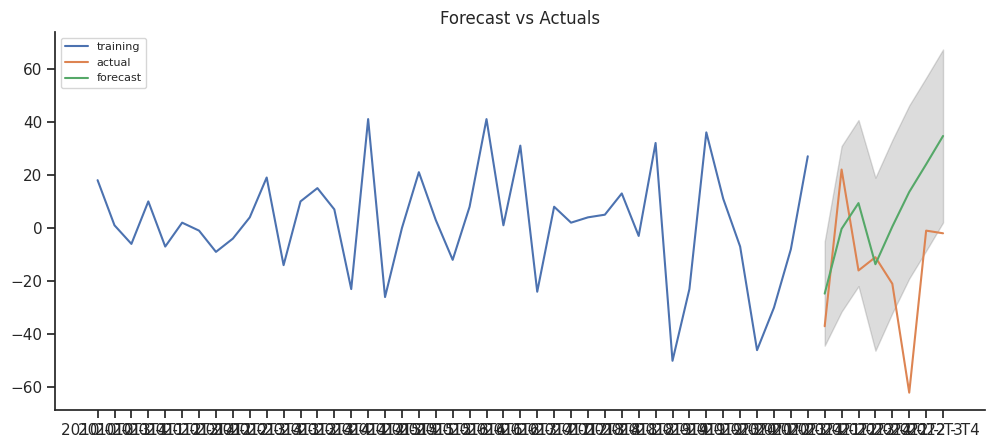

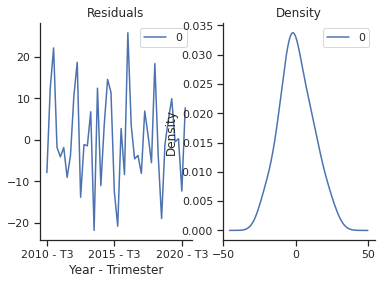

In [ ]:
fc = forecast_resid_error(train_hosp_trim['TOTAL_CRIMES_SHIFT'], 
                          valid_hosp_trim['TOTAL_CRIMES_SHIFT'], 
                          model_fit, 
                          valid_hosp_trim.drop(['TOTAL_CRIMES', 'TOTAL_CRIMES_SHIFT'], axis=1))

The quality of the forecasts could be improved. We could make many more tests by adding/removing variables or even by using only lags to make predictions (univariate models), but we decided to continue with this model.

In addition, residuals are the difference between fitted and observed values. It is very important to analyze them, because they can give us information about how the model is fitting. There are two main properties that residuals have to achieve:
* residuals must be uncorrelated between them; if not, it means there is still information in the residuals that is not being used
* residuals must have zero mean

If these two conditions are not met, the model has not adequately represented our data.

The table below shows us the predictions for the year 2021.

In [ ]:
# Show 4 trimesters (total crime forecasts)
frcst = pd.DataFrame({'frcst':fc,
                      'valid':valid_hosp_trim['TOTAL_CRIMES_SHIFT'],
                      'dif':fc-valid_hosp_trim['TOTAL_CRIMES_SHIFT'],
                      'dif%':fc/valid_hosp_trim['TOTAL_CRIMES_SHIFT']})

frcst = frcst.head()

frcst

,frcst,valid,dif,dif%
Year - Trimester,,,,
2021 - T1,-24.714907,-37.0,12.285093,0.667970
2021 - T2,-0.326315,22.0,-22.326315,-0.014832
2021 - T3,9.366497,-16.0,25.366497,-0.585406
2021 - T4,-13.647442,-11.0,-2.647442,1.240677
2022 - T1,0.513283,-21.0,21.513283,-0.024442


In [ ]:
# Subtract the predicted variation to the actual number of crimes
ts_hospital_trim['TOTAL_CRIMES_PREDICTED'] = round(ts_hospital_trim['TOTAL_CRIMES'] - frcst['frcst'], 0)

ts_hospital_trim = ts_hospital_trim.tail(8).head(4)[['TOTAL_CRIMES_PREDICTED', 'TOTAL_CRIMES']]
ts_hospital_trim

,TOTAL_CRIMES_PREDICTED,TOTAL_CRIMES
Year - Trimester,,
2021 - T1,130.0,105
2021 - T2,127.0,127
2021 - T3,102.0,111
2021 - T4,114.0,100


In order to include this metric in the Women's Safety Index, we need to normalize the total number of predicted crimes to a value between 0 and 1. For this purpose, we will use the **MinMaxScaler**.

In [ ]:
scaler = MinMaxScaler()
ts_hospital_trim['TOTAL_CRIMES_PREDICTED_SCALED'] = scaler.fit_transform(ts_hospital_trim['TOTAL_CRIMES_PREDICTED'].to_numpy().reshape(-1, 1))
ts_hospital_trim

,TOTAL_CRIMES_PREDICTED,TOTAL_CRIMES,TOTAL_CRIMES_PREDICTED_SCALED
Year - Trimester,,,
2021 - T1,130.0,105,1.000000
2021 - T2,127.0,127,0.892857
2021 - T3,102.0,111,0.000000
2021 - T4,114.0,100,0.428571


#### 6.4) Women's Safety Index (WSI)

In order to calculate the Women's Safety Index, the following formula was used:

$ WSI = \frac{TOTAL\_CRIMES\_PREDICTED\_SCALED + Socioeconomic Variable}{2}$

A higher value of this Index corresponds to more insecurity.

##### 6.4.1) Socioeconomic Variable

We will start by calculating the **Socioeconomic Variable**.

We consider the following variables to be important for safety in cities:

**SECURITY**

- % of women (or number of cases) who experienced domestic violence (intimate partner violence) [6]
- Community safety -> measured by the number of violent crimes (murder, rape, kidnapping, abduction) [6] OR Number of crimes in general [7]
- Organized violence -> measured by the number of gang/battle deaths per 1 000 people [6]
- Number of women victims visiting the police stations [7]
- Number of complaints for street harassment against women [7]
- Number of police stations per 1 000 people -> (No. of pol stations / Population of the district) * 1 000 [8]
- Public security -> Number of entertainment businesses or restaurants [9]

**SOCIO-ECONOMIC AND DEMOGRAPHIC**

- Population density [9]
- Social Development Index for Economy (residential electricity, internet access) [9]
- % of women employed (representing inclusion) [6]

**TRANSPORT**

- Bus Availability -> presence of public transport in urban areas per 1 000 population [10]

However, the variables that we have access to are:

In [ ]:
district.columns

Index(['PCD', '{Provincia, Canton, Distrito}',
       'Tasa de Asaltos por cada 10 mil habitantes',
       'Tasa de Homicidios dolosos por cada 10 mil habitantes',
       'Tasa de Hurtos por cada 10 mil habitantes',
       'Tasa de Robos por cada 10 mil habitantes',
       'Tasa de Robo de vehículos por cada 10 mil habitantes',
       'Tasa de Violaciones por cada 10 mil habitantes', 'Económica',
       'Participación electoral', 'Salud', 'Educación', 'Seguridad',
       'IDS 2017', 'Población total', 'Densidad de población',
       'Porcentaje población urbana', 'Relación hombres mujeres',
       'Relación dependencia demográfica',
       'Porcentaje de población de 65 años y más',
       'Porcentaje de población nacida en el extranjero',
       'Porcentaje de personas unidas o casadas', 'Porcentaje de discapacidad',
       'Porcentaje de población no asegurada', 'provincia', 'canton',
       'distrito'],
      dtype='object')

Let's use a correlation matrix to identify which features may influence the most the safety ("Seguridad") in a certain district.

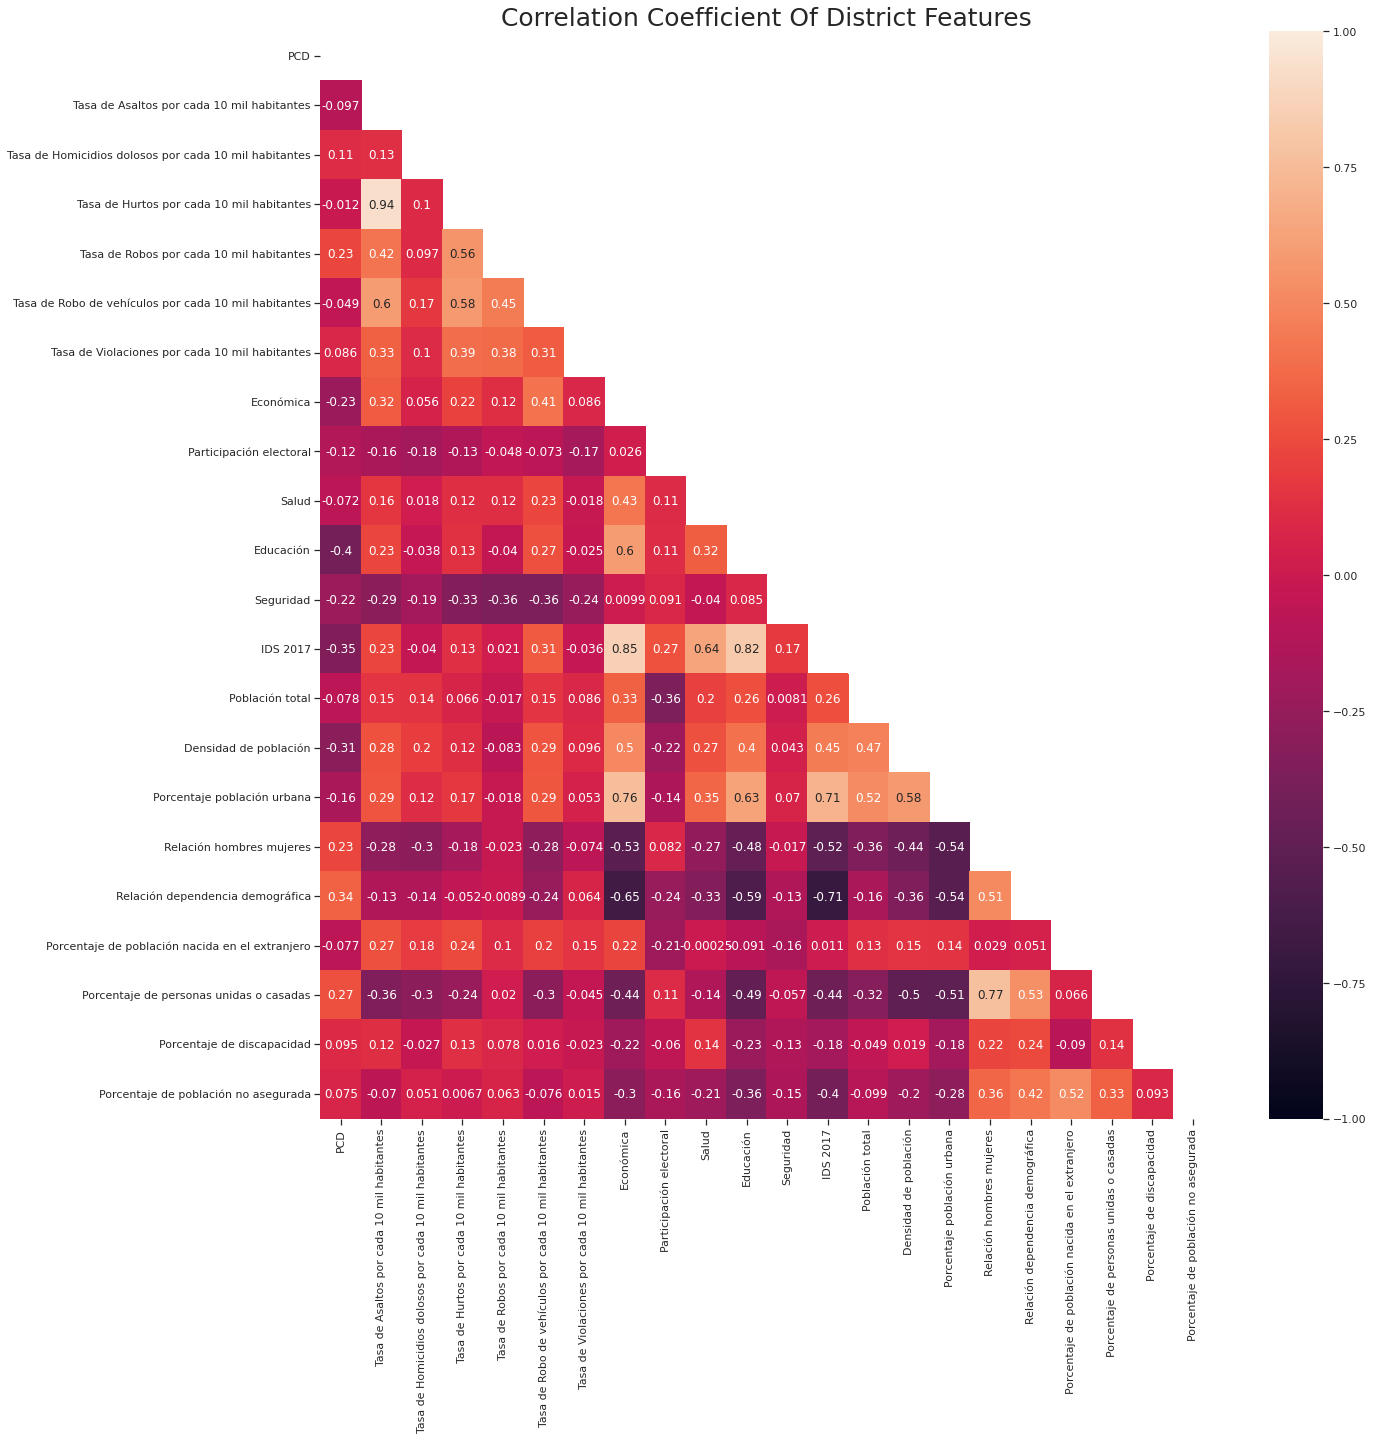

In [ ]:
# Plot heatmap
plt.figure(figsize=(20,20))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(district.corr(), dtype=bool))

# Generate heatmap
sns.heatmap(district.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of District Features', size=25)
plt.show()

After analysing the previous correlation matrix and intersecting it with the previous information collected and presented in Section 6.4.1, we decided to select as important fetures for the calculus of the Women's Safety Index the following:
* **Tasa de Violaciones por cada 10 mil habitantes**
* **Tasa de Asaltos, Homicidios dolosos, Hurtos e Robos por cada 10 mil habitantes**
* **Seguridad**
* **Densidad de población**
* **Económica**


In [ ]:
# Scale the features between 0 and 1
scaler = MinMaxScaler()

# Filter the important features
data = district[['Tasa de Violaciones por cada 10 mil habitantes', 
                 'Tasa de Asaltos por cada 10 mil habitantes',
                 'Tasa de Homicidios dolosos por cada 10 mil habitantes',
                 'Tasa de Robos por cada 10 mil habitantes',
                 'Densidad de población', 
                 'Seguridad', 
                 'Económica']]

# Transform data
scaled = scaler.fit_transform(data)
scaled = pd.DataFrame(scaled)
scaled['index'] = scaled.mean(numeric_only=True, axis=1)
scaled = scaled.join(district['distrito'])
scaled = scaled.set_index('distrito')

# Function to get the index requested
def get_social_ec(distrito):
    var = scaled.loc[distrito]['index']
    var = round(var, 2)
    return var

In [ ]:
# Hospital and Catedral Socioeconomic Variable
hospital_var = get_social_ec('HOSPITAL')
catedral_var = get_social_ec('CATEDRAL')

print(f'Hospital: {hospital_var}')
print(f'Catedral: {catedral_var}')

Hospital: 0.34
Catedral: 0.36


##### 6.4.2) Index Calculation

In [ ]:
# Calculate according to the formula defined above
ts_hospital_trim['Women Safety Index'] = (ts_hospital_trim['TOTAL_CRIMES_PREDICTED_SCALED'] + hospital_var)/2
ts_hospital_trim[['Women Safety Index']]

,Women Safety Index
Year - Trimester,
2021 - T1,0.670000
2021 - T2,0.616429
2021 - T3,0.170000
2021 - T4,0.384286


In [ ]:
ts_catedral_trim['Women Safety Index'] = (ts_catedral_trim['TOTAL_CRIMES_PREDICTED_SCALED'] + catedral_var)/2
ts_catedral_trim[['Women Safety Index']]

,Women Safety Index
Year - Trimester,
2021 - T1,0.547647
2021 - T2,0.327059
2021 - T3,0.180000
2021 - T4,0.680000


In 2021, the districts of Hospital and Catedral presented the Women's Security Indexes presented above. Some insights taken from the analysis can be:
* In the first half of the year, the Hospital district was the most insecure, with indexes above 0.5. On the second half of the year, the Catedral district was the most insecure.
* The third trimester of 2021 was the most secure, with lower values of the Women's Safety Index.
* The highest difference in the index between the districts is in the last trimester of the year, with Catedral being more insecure.

### 7. Conclusion 

#### 7.1) Women's Safety Index Predictions (Safety Map)

We believe the main product from our code would be a Safety Map depicting our predictions for the Women’s Safety Index in each San Jose district, in a similar way to the mockup below.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/2012_Crime_Rate_against_Women_per_100000_in_India_by_its_States_and_Union_Territories%2C_VAW_Map.svg/1200px-2012_Crime_Rate_against_Women_per_100000_in_India_by_its_States_and_Union_Territories%2C_VAW_Map.svg.png" alt="Safety Map" width="350"/>

With this, women could see how safe/unsafe a specific district will be in the next 4 trimesters or 2 years, according to our Index, by interacting with an online platform created for that purpose. If a district seems to be getting unsafe in the future, women can try to avoid passing too much time there. 

This can be a powerful tool to reduce crimes against women in public spaces, as they have the right to an inclusive and safe city.

#### 7.2) Solutions and Implementations

We will now propose some possible solutions for the issue of women safety in San Jose, Costa Rica. These are mainly directed to two groups: women living in the city and San Jose's City Council. We believe these are the people which can more likely influence positive change.

Therefore, in order to help Urbanalytica in transforming San Jose into a safer city for women and girls, we suggest the following measures:

1. Encourage women to **check a map** like the one in Section 7.1. Using the information on the platform, they could check the safety predictions for each district and act accordingly. If the district seemed to be too unsafe, women could avoid passing there to not get stolen or assaulted. This could reduce the number of women and girls exposed to dangerous regions. Also, if the city council had access to this information, maybe it would be possible to raise awareness among policymakers.

2. Some **campaigns** could be done to educate citizens, using flyers, outdoor posters, and most importantly, social media. This would explain how women can access and use the online platform to check our Safety Index predictions. It could also explain the main problems with gender violence, and what could be done to end it.

3. To tackle the issue of **street harassment**, we recommend police stations to start sharing anonymous data about these types of crime. If we had the coordinates of where a street harassment crime occured and a short description of it (redacting the personal data of the victim, to keep all reports anonymous), we could pinpoint it on our Safety Map. Then, women could check which roads/streets in San Jose were more prone to have people committing sexual harassment, exhibitionism, pursuit, cornering, and production of audiovisual material. This would be similar to the concept of the SafeCity web app created by the Red Dot Foundation ([see here](https://webapp.safecity.in/)).

#### 7.3) Future Work

- If more data about street harassment reports was stored, then the *costa_rica_street_harassment_english.csv* file could be used for more analysis. Still, at the moment, there is not much data to use regarding the important issue of harassment (probably because the *Law Against
Street Sexual Harassment* was approved in Costa Rica only 2 years ago, and some women still do not know about it).
- Our predictions could be extended to more regions of Costa Rica, baring in mind that urban and rural areas might have very different realities. Thus, this project could be turned into more of a high-level analysis from which all the citizens could benefit from.

## 🖼️ Visualisations
**Visualisation 1:** Number of Public Areas per Km2

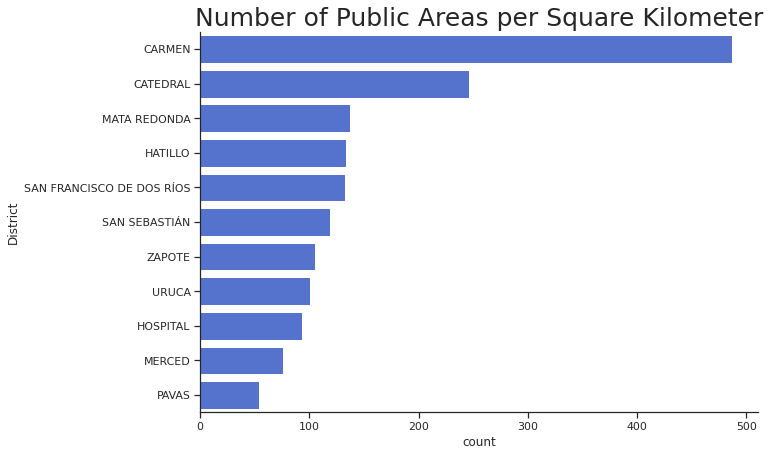

In [ ]:
from IPython.display import Image
Image(filename=path + '/images/public_areas_km2.png')

**Visualisation 2:** Crime Rate in the San Jose's Districts

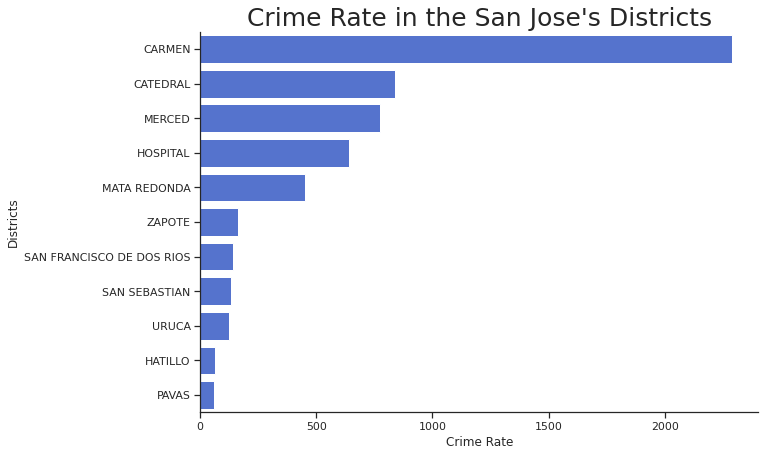

In [ ]:
Image(filename=path + '/images/crime_rate_districts.png')

**Visualisation 3:** Number of Crimes Against Women

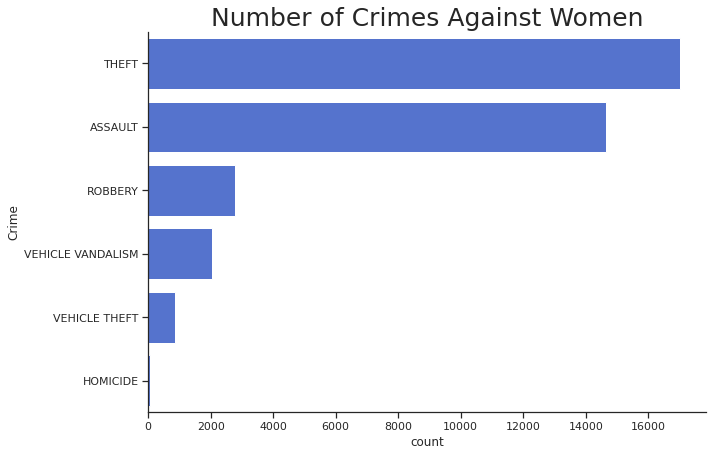

In [ ]:
Image(filename=path + '/images/crimes_against_women.png')

**Visualisation 4:** % of Crimes that are Committed in each Year

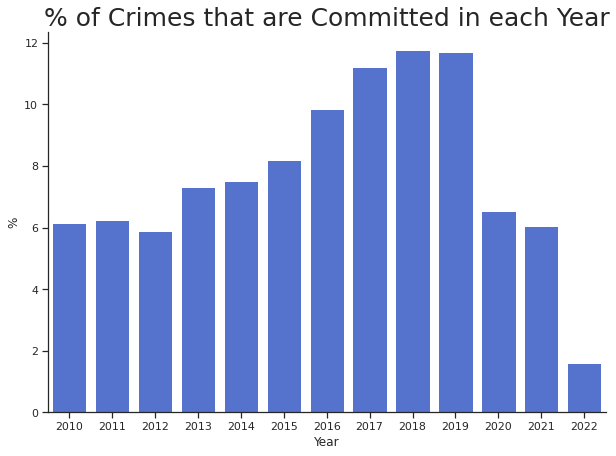

In [ ]:
Image(filename=path + '/images/per_year.png')

**Visualisation 5:** Number of Crimes per District

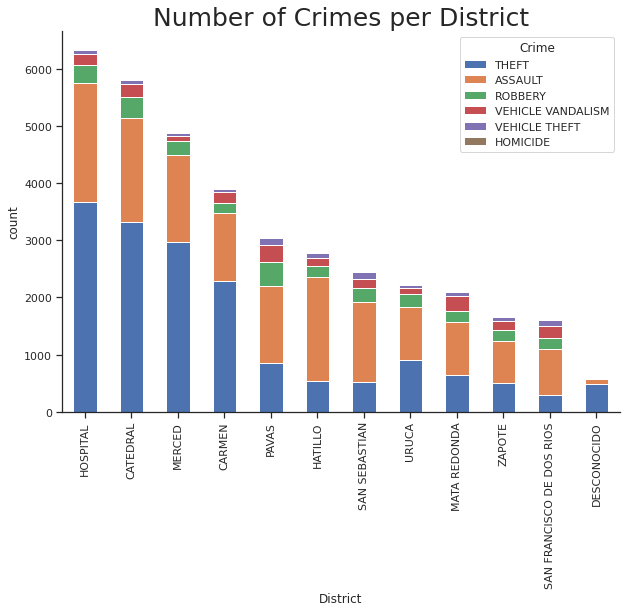

In [ ]:
Image(filename=path + '/images/per_district.png')

**Visualisation 6:** Total Number of Street Harassment Reports per District

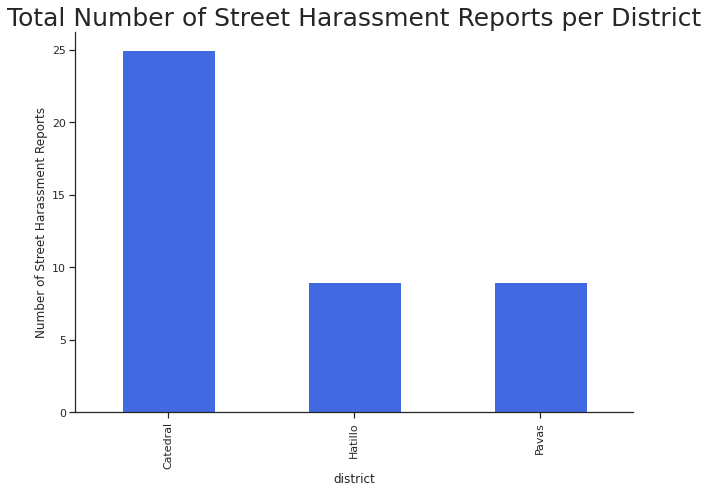

In [ ]:
Image(filename=path + '/images/harassment.png')

**Visualisation 7:** Wordcloud for the Park Ratings

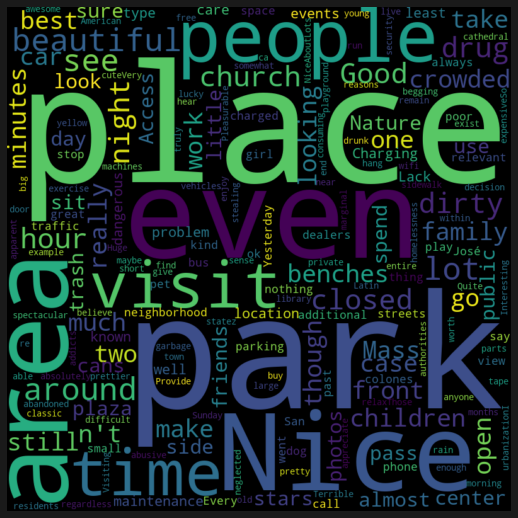

In [ ]:
Image(filename=path + '/images/wordcloud_parks.png')

**Visualisation 8:** Wordcloud for the Transit Stations Ratings

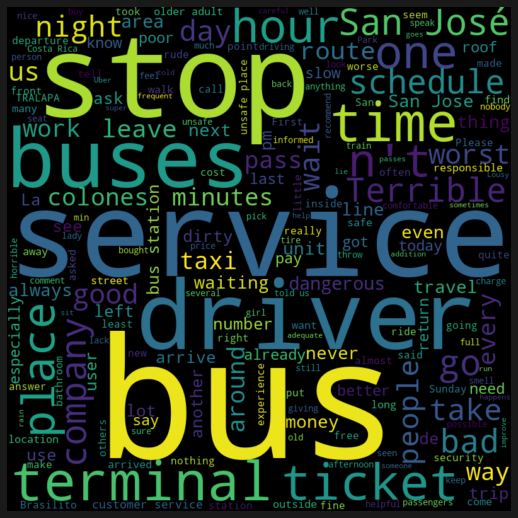

In [ ]:
Image(filename=path + '/images/wordcloud_stations.png')

**Visualisation 9:** Forecasts for the Hospital district (Trimester)

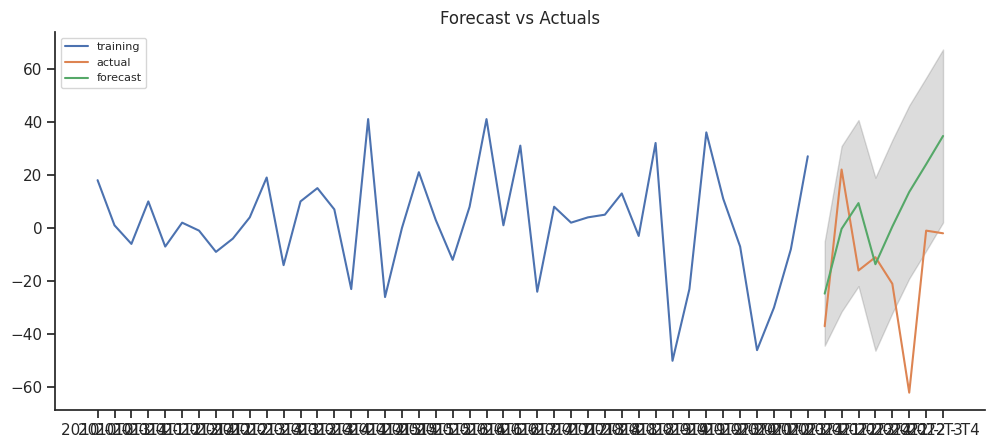

In [ ]:
Image(filename=path + '/images/forecasts_hospital.png')

## 👓 References

[1] United Nations Department of Economic and Social Affairs. "Make cities and human settlements inclusive, safe, resilient and sustainable". Available at: https://sdgs.un.org/goals/goal11

[2] Inter-American Convention on the Prevention, Punishment, and Eradication of Violence against Women (Convention of Belém do Pará), 1994. Available at: https://www.oas.org/juridico/english/treaties/a-61.html

[3] Infosegura. "Violence against women, Costa Rica 2020". Available at: https://infosegura.org/wp-content/uploads/2021/06/VCM-COSTA-RICA-2020-ENG.pdf

[4] United Nations Entity for Gender Equality and the Empowerment of Women. "Safe Cities and Safe Public Spaces: Global results report". Available at: https://www.unwomen.org/en/digital-library/publications/2017/10/safe-cities-and-safe-public-spaces-global-results-report

[5] Observatorio de Violencia de Género contra las Mujeres y Acceso a la Justicia. "Fortalecer los derechos de las mujeres es fortalecer la Democracia". Available at: https://observatoriodegenero.poder-judicial.go.cr/

[6] Georgetown Institute for Women, Peace and Security. "Women Peace and Security Index 2019/20". Available at: https://reliefweb.int/sites/reliefweb.int/files/resources/WPS-Index-2019-Report.pdf

[7] India Urban Data Exchange. "Women's Safety Index". Available at: https://sites.google.com/view/iudx-technical/womens-safety-index

[8] Safetipin. "Guidelines for an Index on Gender Friendly Cities". Available at: https://asiafoundation.org/wp-content/uploads/2020/09/Guidelines-for-an-Index-on-Gender-Friendly-Cities-Report_India.pdf

[9] Chang, M. H., & Rho, S. (2016). Development of a Women's Safety Index on Gender-based Violence: A Cross-Regional Analysis of Risk Factors in Seoul City, South Korea.

[10] Kaur, P., Dixit, R., & Choudhary, S. (2019). Creation and Data Analysis of Women Safety Index of Delhi and Its Neighbouring Cities.

[11] Ministry of Planing and Economic Policy. "Social Development Index". Available at: https://www.mideplan.go.cr/indice-desarrollo-social

## ⏭️ Appendix

**Appendix A:** Transit Stations Data Processing


In [ ]:
# Normalize json into a pandas DataFrame
transit_df = json_normalize(transit_df['transit_reviews'])
transit_df = transit_df.where(pd.notnull(transit_df), None)

In [ ]:
# ⚙️ FEATURE ENGINEERING (Median, Standard Deviation and Text from low ratings)
Medians = list()
Var = list()
Three_star_text = list()

for ind in transit_df.index:
    reviews = transit_df.loc[ind]['result.reviews']

    if reviews is None:
        median = None 
        st_var = None
        text = None
    else:
        rating_vector = list()
        text = ''

        for review in reviews:
            rating_vector.append(review['rating'])
            if review['rating'] <= 3:
                text += review['text']

        rating_vector = np.asarray(rating_vector)
        median = statistics.median(rating_vector)
        st_var = np.std(rating_vector)

    Medians.append(median)
    Var.append(st_var)
    Three_star_text.append(text)

# Add features to dataset
transit_df['median'] = Medians
transit_df['variance'] = Var
transit_df['text'] = Three_star_text

In [ ]:
# Convert Formatted Address into DataFrame
location_df = transit_df['result.formatted_address'].str.split(',', n=4, expand=True)

# Filter data by San Jose canton (Since the data is not all correctly formatted, we need 2 columns)
location_df = location_df[(location_df[3] == ' San José') | (location_df[2] == ' San José')]
location_indexes = location_df.index

# Filter transit stations dataset
transit_df = transit_df.loc[location_indexes]

**Appendix B:** Build Time Series by Trimester and Year

In [ ]:
def get_ts_trimester(df):
  # Index time series
  idx = df.groupby(by=['Year','Trimester']).size()

  # Build time series dataframe
  ts = pd.DataFrame(index = idx.index)

  # Total number of crimes by trimester
  ts['TOTAL_CRIMES'] = df.groupby(by=['Year','Trimester']).size().values

  # Group by year, trimester and time of the day
  Time_hosp = df.groupby(by=['Year','Trimester', 'Time']).size()

  # Get times of the day
  times = crimes_san_jose_women['Time'].unique()

  # Fill time series 
  for index in Time_hosp.index:
    for time in times:
      if index[2:]==(time,):
        ts.at[index[:-1], time] = Time_hosp[index]

  # Group by year, trimester and subtype of victim
  SubtypeVictim_hosp = df.groupby(by=['Year','Trimester', 'SubtypeVictim']).size()

  # Since pedestrians represent 40.5% of the dataset, we keep only this variable in the time series
  # Fill time series
  for index in SubtypeVictim_hosp.index:
    if index[2:]==('PEDESTRIAN [PERSON]',):
      ts.at[index[:-1], 'PEDESTRIAN [PERSON]'] = SubtypeVictim_hosp[index]

  # Group by year, trimester and age group
  Age_hosp = df.groupby(by=['Year','Trimester', 'Age']).size()

  # Since the age group of >18 y/o represents the majority of the dataset, we keep only this variable in the time series
  # Fill time series
  for index in Age_hosp.index:
    if index[2:]==('>18 y/o',):
      ts.at[index[:-1], '>18 y/o'] = Age_hosp[index]

  # Fill missing observations with 0
  ts = ts.fillna(0)
  
  return ts

In [ ]:
def get_ts_year(df):
  # Index time series
  idx = df.groupby(by=['Year']).size()

  # Build time series dataframe
  ts = pd.DataFrame(index = idx.index)

  # Total number of crimes by trimester
  ts['TOTAL_CRIMES'] = df.groupby(by=['Year']).size().values

  # Group by year, trimester and time of the day
  Time_hosp = df.groupby(by=['Year', 'Time']).size()

  # Get times of the day
  times = crimes_san_jose_women['Time'].unique()

  # Fill time series 
  for index in Time_hosp.index:
    for time in times:
      if index[1:]==(time,):
        ts.at[index[:-1], time] = Time_hosp[index]

  # Group by year, trimester and subtype of victim
  SubtypeVictim_hosp = df.groupby(by=['Year', 'SubtypeVictim']).size()

  # Since pedestrians represent 40.5% of the dataset, we keep only this variable in the time series
  # Fill time series
  for index in SubtypeVictim_hosp.index:
    if index[1:]==('PEDESTRIAN [PERSON]',):
      ts.at[index[:-1], 'PEDESTRIAN [PERSON]'] = SubtypeVictim_hosp[index]

  # Group by year, trimester and age group
  Age_hosp = df.groupby(by=['Year', 'Age']).size()

  # Since the age group of >18 y/o represents the majority of the dataset, we keep only this variable in the time series
  # Fill time series
  for index in Age_hosp.index:
    if index[1:]==('>18 y/o',):
      ts.at[index[:-1], '>18 y/o'] = Age_hosp[index]

  # Fill missing observations with 0
  ts = ts.fillna(0)
  
  return ts

**Appendix C:** Modelling for Catedral (Trimester)

In [ ]:
# Dataset
ts_catedral_trim = ts_catedral_trim.reset_index()
ts_catedral_trim['Year'] = ts_catedral_trim['Year'].astype(str)
ts_catedral_trim['Trimester'] = ts_catedral_trim['Trimester'].astype(str)
ts_catedral_trim['Year - Trimester'] = ts_catedral_trim['Year'] + ' - T' + ts_catedral_trim['Trimester']
ts_catedral_trim = ts_catedral_trim.drop(columns=['Year', 'Trimester']).set_index('Year - Trimester')

# Shift
ts_catedral_trim['TOTAL_CRIMES_SHIFT'] = ts_catedral_trim['TOTAL_CRIMES'] - ts_catedral_trim['TOTAL_CRIMES'].shift(1)
ts_catedral_trim = ts_catedral_trim.dropna()

# Creating the train and validation set
train_catedral_trim = ts_catedral_trim.loc[:'2020 - T4']
valid_catedral_trim = ts_catedral_trim.loc['2021 - T1':]

In [ ]:
# Optimize model
train_catedral_trim_result = optimize_ARIMA(parameters_list, 
                                  train_catedral_trim['TOTAL_CRIMES_SHIFT'], 
                                  train_catedral_trim.drop(['TOTAL_CRIMES', 'TOTAL_CRIMES_SHIFT'], axis=1))


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
train_catedral_trim_result.head(3)

,parameters,aic
0,"(2, 1)",378.177084
1,"(3, 1)",380.713194
2,"(4, 2)",384.380094


In [ ]:
# Model to predict TOTAL_CRIMES
model = ARIMA(endog=train_catedral_trim['TOTAL_CRIMES_SHIFT'], 
              exog=train_catedral_trim.drop(['TOTAL_CRIMES', 'TOTAL_CRIMES_SHIFT'], axis=1), 
              order=(2,1,1))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

                              ARIMA Model Results                               
Dep. Variable:     D.TOTAL_CRIMES_SHIFT   No. Observations:                   42
Model:                   ARIMA(2, 1, 1)   Log Likelihood                -174.089
Method:                         css-mle   S.D. of innovations             14.261
Date:                  Mon, 23 May 2022   AIC                            378.177
Time:                          21:18:41   BIC                            404.242
Sample:                               1   HQIC                           387.731
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         17.7919      6.173      2.882      0.008       5.693      29.891
00:00:00 - 02:59:59           -0.7735      0.371     -2.085      0.

{'mape': inf, 'mae': 59.535, 'rmse': 71.007}


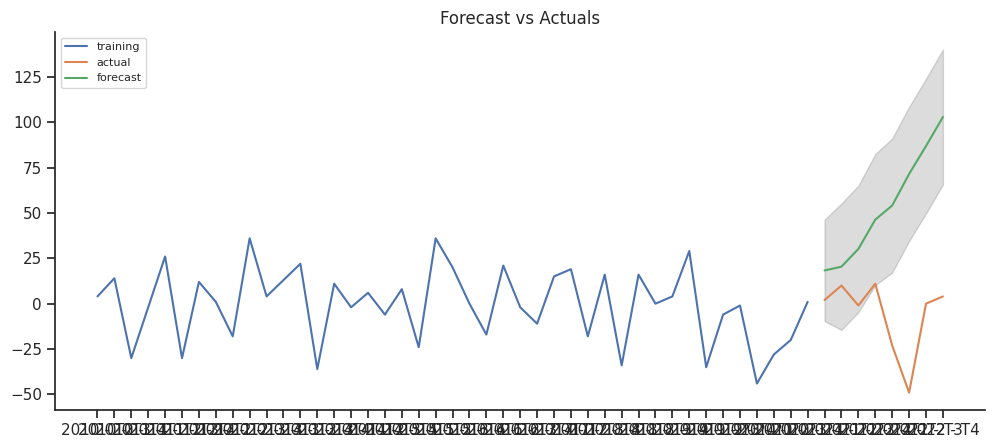

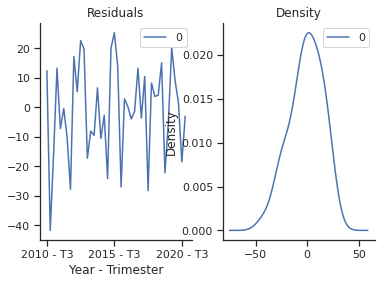

In [ ]:
# Plot forecast
fc_cat = forecast_resid_error(train_catedral_trim['TOTAL_CRIMES_SHIFT'], 
                              valid_catedral_trim['TOTAL_CRIMES_SHIFT'], 
                              model_fit, 
                              valid_catedral_trim.drop(['TOTAL_CRIMES', 'TOTAL_CRIMES_SHIFT'], axis=1))

In [ ]:
# Show 4 trimesters (total crime forecasts)
frcst_cat = pd.DataFrame({'frcst':fc,
                          'valid':valid_catedral_trim['TOTAL_CRIMES_SHIFT'],
                          'dif':fc-valid_catedral_trim['TOTAL_CRIMES_SHIFT'],
                          'dif%':fc/valid_catedral_trim['TOTAL_CRIMES_SHIFT']})

frcst_cat = frcst.head()
frcst_cat

,frcst,valid,dif,dif%
Year - Trimester,,,,
2021 - T1,-24.714907,-37.0,12.285093,0.667970
2021 - T2,-0.326315,22.0,-22.326315,-0.014832
2021 - T3,9.366497,-16.0,25.366497,-0.585406
2021 - T4,-13.647442,-11.0,-2.647442,1.240677
2022 - T1,0.513283,-21.0,21.513283,-0.024442


In [ ]:
# Subtract the predicted variation to the actual number of crimes
ts_catedral_trim['TOTAL_CRIMES_PREDICTED'] = round(ts_catedral_trim['TOTAL_CRIMES'] - frcst_cat['frcst'], 0)

ts_catedral_trim = ts_catedral_trim.tail(8).head(4)[['TOTAL_CRIMES_PREDICTED', 'TOTAL_CRIMES']]
ts_catedral_trim

,TOTAL_CRIMES_PREDICTED,TOTAL_CRIMES
Year - Trimester,,
2021 - T1,87.0,62
2021 - T2,72.0,72
2021 - T3,62.0,71
2021 - T4,96.0,82


In [ ]:
scaler = MinMaxScaler()
ts_catedral_trim['TOTAL_CRIMES_PREDICTED_SCALED'] = scaler.fit_transform(ts_catedral_trim['TOTAL_CRIMES_PREDICTED'].to_numpy().reshape(-1, 1))
ts_catedral_trim

,TOTAL_CRIMES_PREDICTED,TOTAL_CRIMES,TOTAL_CRIMES_PREDICTED_SCALED
Year - Trimester,,,
2021 - T1,87.0,62,0.735294
2021 - T2,72.0,72,0.294118
2021 - T3,62.0,71,0.000000
2021 - T4,96.0,82,1.000000
